In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle


from tensorflow.keras.layers import Dropout,MultiHeadAttention,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate
from tensorflow.keras import callbacks 

from sklearn.model_selection import KFold

In [2]:
#retrieve data
num = 2000 # number of profiles
nvza = 2 # number of channels
nsza=1



In [13]:
#get the averaged reflectance from the dataset 
r=np.load('monte_carlo_r.npy')
r.shape

(2000, 82, 1, 2)

In [15]:
r=r.reshape((2000, 82, 2))

In [16]:
#get the averaged reflectance from the dataset 
c=np.load('monte_carlo_cot.npy')
c.shape

(2000, 82)

In [17]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800
print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')

# spatial slicing dimensions
s = 82 # output slice size
ts = 82 # input slice size 32


train_size: 1600 profiles
test_size: 400 profiles


In [7]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

NameError: name 'model' is not defined

In [18]:
import os
checkpoint_path = "training_random_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [19]:
ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()
bsize = 16
eps = 2000

def eval_model(train_image, test_image, train_label, test_label):

    #bi-LSTM
    input_layer = tf.keras.layers.Input(shape=(ts,2),name='Input')
    #patch embedding layer
    #The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim
    projection=tf.keras.layers.Dense(64,activation='relu')(input_layer)
    positions = tf.range(start=0, limit=82, delta=1)
    embedding=tf.keras.layers.Embedding(input_dim=(82),output_dim=(64),input_length=128)(positions)
    # adds a learnable position embedding to the projected vector
    encoded = projection+embedding

    bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(encoded) #kernel size 6, 100 filters for each 3 channel
    bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(bi) #kernel size 6, 100 filters for each 3 input_layerchannel


    #transformer block
    slf_attn = MultiHeadAttention(num_heads=3,key_dim=3)(bi,bi)
    add1=tf.keras.layers.Add()([slf_attn,bi])
    layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add1)
    dense1=tf.keras.layers.Dense(256,activation='relu')(layernorm1)
    add2=tf.keras.layers.Add()([layernorm1,dense1])
    layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add2)
    
    
    
    flat=tf.keras.layers.Flatten()(layernorm2)



    #output layers
   # dense2 = tf.keras.layers.Dense(42*3,activation='relu')(conc)
    drop=tf.keras.layers.Dropout(.2)(flat)

    output = tf.keras.layers.Dense(82,activation='relu')(drop)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])

    model.summary()
    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    #checkpoint_path='training/cp-{epoch:04d}.ckpt'
    #checkpoint_dir=os.path.dirname(checkpoint_path)
    
  #  cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1,save_freq=5*bsize)
   # model.save_weights(checkpoint_path.format(epoch=0))

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.25,
                              callbacks =[earlystopping,cp_callback])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]
    
    return model,rmse,mse,history,predictions,results

In [21]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,1600,ts,2))
y_train=np.zeros((5,ratio*(n_folds-1),82))
X_test=np.zeros((n_folds,ratio,ts,2))
y_test=np.zeros((n_folds,ratio,82))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index]
    y_train[count], y_test[count] = c[train_index], c[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 400  401  402 ... 1997 1998 1999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

In [22]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions,results= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)




   



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 82, 2)]      0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 82, 64)       192         Input[0][0]                      
__________________________________________________________________________________________________
tf.__operators__.add_1 (TFOpLam (None, 82, 64)       0           dense_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 82, 256)      197632      tf.__operators__.add_1[0][0]     
____________________________________________________________________________________________


Epoch 00016: saving model to training_random_2\cp.ckpt
Epoch 17/2000
75/75 [==============================] - 2s 29ms/step - loss: 7.4147 - mean_squared_error: 7.4147 - root_mean_squared_error: 2.7225 - val_loss: 8.7568 - val_mean_squared_error: 8.7568 - val_root_mean_squared_error: 2.9592

Epoch 00017: saving model to training_random_2\cp.ckpt
Epoch 18/2000
75/75 [==============================] - 2s 29ms/step - loss: 7.6161 - mean_squared_error: 7.6161 - root_mean_squared_error: 2.7585 - val_loss: 8.7404 - val_mean_squared_error: 8.7404 - val_root_mean_squared_error: 2.9564

Epoch 00018: saving model to training_random_2\cp.ckpt
Epoch 19/2000
75/75 [==============================] - 2s 29ms/step - loss: 7.3380 - mean_squared_error: 7.3380 - root_mean_squared_error: 2.7084 - val_loss: 8.4880 - val_mean_squared_error: 8.4880 - val_root_mean_squared_error: 2.9134

Epoch 00019: saving model to training_random_2\cp.ckpt
Epoch 20/2000
75/75 [==============================] - 2s 29ms/step 

75/75 [==============================] - 2s 30ms/step - loss: 6.3114 - mean_squared_error: 6.3114 - root_mean_squared_error: 2.5120 - val_loss: 7.9610 - val_mean_squared_error: 7.9610 - val_root_mean_squared_error: 2.8215

Epoch 00045: saving model to training_random_2\cp.ckpt
Epoch 46/2000
75/75 [==============================] - 2s 29ms/step - loss: 6.0405 - mean_squared_error: 6.0405 - root_mean_squared_error: 2.4563 - val_loss: 8.1070 - val_mean_squared_error: 8.1070 - val_root_mean_squared_error: 2.8473

Epoch 00046: saving model to training_random_2\cp.ckpt
Epoch 47/2000
75/75 [==============================] - 2s 30ms/step - loss: 6.4141 - mean_squared_error: 6.4141 - root_mean_squared_error: 2.5325 - val_loss: 8.0355 - val_mean_squared_error: 8.0355 - val_root_mean_squared_error: 2.8347

Epoch 00047: saving model to training_random_2\cp.ckpt
Epoch 48/2000
75/75 [==============================] - 2s 29ms/step - loss: 6.4537 - mean_squared_error: 6.4537 - root_mean_squared_error:

75/75 [==============================] - 2s 30ms/step - loss: 0.5304 - mean_squared_error: 0.5304 - root_mean_squared_error: 0.7283 - val_loss: 2.1337 - val_mean_squared_error: 2.1337 - val_root_mean_squared_error: 1.4607

Epoch 00101: saving model to training_random_2\cp.ckpt
Epoch 102/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.5108 - mean_squared_error: 0.5108 - root_mean_squared_error: 0.7147 - val_loss: 2.0946 - val_mean_squared_error: 2.0946 - val_root_mean_squared_error: 1.4473

Epoch 00102: saving model to training_random_2\cp.ckpt
Epoch 103/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.4803 - mean_squared_error: 0.4803 - root_mean_squared_error: 0.6930 - val_loss: 2.1359 - val_mean_squared_error: 2.1359 - val_root_mean_squared_error: 1.4615

Epoch 00103: saving model to training_random_2\cp.ckpt
Epoch 104/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.5000 - mean_squared_error: 0.5000 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.4439 - mean_squared_error: 0.4439 - root_mean_squared_error: 0.6663 - val_loss: 1.9757 - val_mean_squared_error: 1.9757 - val_root_mean_squared_error: 1.4056

Epoch 00129: saving model to training_random_2\cp.ckpt
Epoch 130/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.4191 - mean_squared_error: 0.4191 - root_mean_squared_error: 0.6473 - val_loss: 1.9862 - val_mean_squared_error: 1.9862 - val_root_mean_squared_error: 1.4093

Epoch 00130: saving model to training_random_2\cp.ckpt
Epoch 131/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.4096 - mean_squared_error: 0.4096 - root_mean_squared_error: 0.6399 - val_loss: 2.0359 - val_mean_squared_error: 2.0359 - val_root_mean_squared_error: 1.4268

Epoch 00131: saving model to training_random_2\cp.ckpt
Epoch 132/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.4120 - mean_squared_error: 0.4120 - root_mean_squared_err

75/75 [==============================] - 2s 29ms/step - loss: 0.3576 - mean_squared_error: 0.3576 - root_mean_squared_error: 0.5980 - val_loss: 1.8543 - val_mean_squared_error: 1.8543 - val_root_mean_squared_error: 1.3617

Epoch 00157: saving model to training_random_2\cp.ckpt
Epoch 158/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.3539 - mean_squared_error: 0.3539 - root_mean_squared_error: 0.5949 - val_loss: 1.8632 - val_mean_squared_error: 1.8632 - val_root_mean_squared_error: 1.3650

Epoch 00158: saving model to training_random_2\cp.ckpt
Epoch 159/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3600 - mean_squared_error: 0.3600 - root_mean_squared_error: 0.6000 - val_loss: 1.8881 - val_mean_squared_error: 1.8881 - val_root_mean_squared_error: 1.3741

Epoch 00159: saving model to training_random_2\cp.ckpt
Epoch 160/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3661 - mean_squared_error: 0.3661 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.3466 - mean_squared_error: 0.3466 - root_mean_squared_error: 0.5886 - val_loss: 1.8407 - val_mean_squared_error: 1.8407 - val_root_mean_squared_error: 1.3567

Epoch 00185: saving model to training_random_2\cp.ckpt
Epoch 186/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3239 - mean_squared_error: 0.3239 - root_mean_squared_error: 0.5690 - val_loss: 1.7959 - val_mean_squared_error: 1.7959 - val_root_mean_squared_error: 1.3401

Epoch 00186: saving model to training_random_2\cp.ckpt
Epoch 187/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3247 - mean_squared_error: 0.3247 - root_mean_squared_error: 0.5698 - val_loss: 1.7958 - val_mean_squared_error: 1.7958 - val_root_mean_squared_error: 1.3401

Epoch 00187: saving model to training_random_2\cp.ckpt
Epoch 188/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3099 - mean_squared_error: 0.3099 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.3034 - mean_squared_error: 0.3034 - root_mean_squared_error: 0.5508 - val_loss: 1.7485 - val_mean_squared_error: 1.7485 - val_root_mean_squared_error: 1.3223

Epoch 00213: saving model to training_random_2\cp.ckpt
Epoch 214/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3146 - mean_squared_error: 0.3146 - root_mean_squared_error: 0.5609 - val_loss: 1.7695 - val_mean_squared_error: 1.7695 - val_root_mean_squared_error: 1.3302

Epoch 00214: saving model to training_random_2\cp.ckpt
Epoch 215/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3020 - mean_squared_error: 0.3020 - root_mean_squared_error: 0.5495 - val_loss: 1.7246 - val_mean_squared_error: 1.7246 - val_root_mean_squared_error: 1.3133

Epoch 00215: saving model to training_random_2\cp.ckpt
Epoch 216/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2923 - mean_squared_error: 0.2923 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2835 - mean_squared_error: 0.2835 - root_mean_squared_error: 0.5323 - val_loss: 1.7132 - val_mean_squared_error: 1.7132 - val_root_mean_squared_error: 1.3089

Epoch 00241: saving model to training_random_2\cp.ckpt
Epoch 242/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3143 - mean_squared_error: 0.3143 - root_mean_squared_error: 0.5606 - val_loss: 1.6693 - val_mean_squared_error: 1.6693 - val_root_mean_squared_error: 1.2920

Epoch 00242: saving model to training_random_2\cp.ckpt
Epoch 243/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2988 - mean_squared_error: 0.2988 - root_mean_squared_error: 0.5466 - val_loss: 1.6541 - val_mean_squared_error: 1.6541 - val_root_mean_squared_error: 1.2861

Epoch 00243: saving model to training_random_2\cp.ckpt
Epoch 244/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2793 - mean_squared_error: 0.2793 - root_mean_squared_err

75/75 [==============================] - 2s 29ms/step - loss: 0.2757 - mean_squared_error: 0.2757 - root_mean_squared_error: 0.5250 - val_loss: 1.6121 - val_mean_squared_error: 1.6121 - val_root_mean_squared_error: 1.2697

Epoch 00269: saving model to training_random_2\cp.ckpt
Epoch 270/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2556 - mean_squared_error: 0.2556 - root_mean_squared_error: 0.5055 - val_loss: 1.6122 - val_mean_squared_error: 1.6122 - val_root_mean_squared_error: 1.2697

Epoch 00270: saving model to training_random_2\cp.ckpt
Epoch 271/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2607 - mean_squared_error: 0.2607 - root_mean_squared_error: 0.5105 - val_loss: 1.5825 - val_mean_squared_error: 1.5825 - val_root_mean_squared_error: 1.2580

Epoch 00271: saving model to training_random_2\cp.ckpt
Epoch 272/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2526 - mean_squared_error: 0.2526 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2368 - mean_squared_error: 0.2368 - root_mean_squared_error: 0.4865 - val_loss: 1.5082 - val_mean_squared_error: 1.5082 - val_root_mean_squared_error: 1.2281

Epoch 00325: saving model to training_random_2\cp.ckpt
Epoch 326/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2372 - mean_squared_error: 0.2372 - root_mean_squared_error: 0.4870 - val_loss: 1.5028 - val_mean_squared_error: 1.5028 - val_root_mean_squared_error: 1.2259

Epoch 00326: saving model to training_random_2\cp.ckpt
Epoch 327/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2506 - mean_squared_error: 0.2506 - root_mean_squared_error: 0.5006 - val_loss: 1.5101 - val_mean_squared_error: 1.5101 - val_root_mean_squared_error: 1.2289

Epoch 00327: saving model to training_random_2\cp.ckpt
Epoch 328/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2361 - mean_squared_error: 0.2361 - root_mean_squared_err

75/75 [==============================] - 2s 29ms/step - loss: 0.2375 - mean_squared_error: 0.2375 - root_mean_squared_error: 0.4873 - val_loss: 1.4848 - val_mean_squared_error: 1.4848 - val_root_mean_squared_error: 1.2185

Epoch 00353: saving model to training_random_2\cp.ckpt
Epoch 354/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2489 - mean_squared_error: 0.2489 - root_mean_squared_error: 0.4989 - val_loss: 1.5208 - val_mean_squared_error: 1.5208 - val_root_mean_squared_error: 1.2332

Epoch 00354: saving model to training_random_2\cp.ckpt
Epoch 355/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2376 - mean_squared_error: 0.2376 - root_mean_squared_error: 0.4874 - val_loss: 1.4912 - val_mean_squared_error: 1.4912 - val_root_mean_squared_error: 1.2211

Epoch 00355: saving model to training_random_2\cp.ckpt
Epoch 356/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2382 - mean_squared_error: 0.2382 - root_mean_squared_err

75/75 [==============================] - 2s 29ms/step - loss: 0.2264 - mean_squared_error: 0.2264 - root_mean_squared_error: 0.4757 - val_loss: 1.4149 - val_mean_squared_error: 1.4149 - val_root_mean_squared_error: 1.1895

Epoch 00381: saving model to training_random_2\cp.ckpt
Epoch 382/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2292 - mean_squared_error: 0.2292 - root_mean_squared_error: 0.4785 - val_loss: 1.4695 - val_mean_squared_error: 1.4695 - val_root_mean_squared_error: 1.2122

Epoch 00382: saving model to training_random_2\cp.ckpt
Epoch 383/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2471 - mean_squared_error: 0.2471 - root_mean_squared_error: 0.4970 - val_loss: 1.4399 - val_mean_squared_error: 1.4399 - val_root_mean_squared_error: 1.2000

Epoch 00383: saving model to training_random_2\cp.ckpt
Epoch 384/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2321 - mean_squared_error: 0.2321 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2220 - mean_squared_error: 0.2220 - root_mean_squared_error: 0.4712 - val_loss: 1.3726 - val_mean_squared_error: 1.3726 - val_root_mean_squared_error: 1.1716

Epoch 00409: saving model to training_random_2\cp.ckpt
Epoch 410/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2207 - mean_squared_error: 0.2207 - root_mean_squared_error: 0.4698 - val_loss: 1.3878 - val_mean_squared_error: 1.3878 - val_root_mean_squared_error: 1.1780

Epoch 00410: saving model to training_random_2\cp.ckpt
Epoch 411/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2254 - mean_squared_error: 0.2254 - root_mean_squared_error: 0.4747 - val_loss: 1.3892 - val_mean_squared_error: 1.3892 - val_root_mean_squared_error: 1.1786

Epoch 00411: saving model to training_random_2\cp.ckpt
Epoch 412/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2248 - mean_squared_error: 0.2248 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2104 - mean_squared_error: 0.2104 - root_mean_squared_error: 0.4586 - val_loss: 1.4078 - val_mean_squared_error: 1.4078 - val_root_mean_squared_error: 1.1865

Epoch 00465: saving model to training_random_2\cp.ckpt
Epoch 466/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2146 - mean_squared_error: 0.2146 - root_mean_squared_error: 0.4631 - val_loss: 1.3145 - val_mean_squared_error: 1.3145 - val_root_mean_squared_error: 1.1465

Epoch 00466: saving model to training_random_2\cp.ckpt
Epoch 467/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1983 - mean_squared_error: 0.1983 - root_mean_squared_error: 0.4453 - val_loss: 1.2956 - val_mean_squared_error: 1.2956 - val_root_mean_squared_error: 1.1382

Epoch 00467: saving model to training_random_2\cp.ckpt
Epoch 468/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2028 - mean_squared_error: 0.2028 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2292 - mean_squared_error: 0.2292 - root_mean_squared_error: 0.4787 - val_loss: 1.3014 - val_mean_squared_error: 1.3014 - val_root_mean_squared_error: 1.1408

Epoch 00493: saving model to training_random_2\cp.ckpt
Epoch 494/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2290 - mean_squared_error: 0.2290 - root_mean_squared_error: 0.4786 - val_loss: 1.2855 - val_mean_squared_error: 1.2855 - val_root_mean_squared_error: 1.1338

Epoch 00494: saving model to training_random_2\cp.ckpt
Epoch 495/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2127 - mean_squared_error: 0.2127 - root_mean_squared_error: 0.4612 - val_loss: 1.3593 - val_mean_squared_error: 1.3593 - val_root_mean_squared_error: 1.1659

Epoch 00495: saving model to training_random_2\cp.ckpt
Epoch 496/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2177 - mean_squared_error: 0.2177 - root_mean_squared_err

75/75 [==============================] - 2s 29ms/step - loss: 0.2050 - mean_squared_error: 0.2050 - root_mean_squared_error: 0.4528 - val_loss: 1.2461 - val_mean_squared_error: 1.2461 - val_root_mean_squared_error: 1.1163

Epoch 00521: saving model to training_random_2\cp.ckpt
Epoch 522/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2058 - mean_squared_error: 0.2058 - root_mean_squared_error: 0.4537 - val_loss: 1.2661 - val_mean_squared_error: 1.2661 - val_root_mean_squared_error: 1.1252

Epoch 00522: saving model to training_random_2\cp.ckpt
Epoch 523/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1901 - mean_squared_error: 0.1901 - root_mean_squared_error: 0.4360 - val_loss: 1.2446 - val_mean_squared_error: 1.2446 - val_root_mean_squared_error: 1.1156

Epoch 00523: saving model to training_random_2\cp.ckpt
Epoch 524/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1921 - mean_squared_error: 0.1921 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1969 - mean_squared_error: 0.1969 - root_mean_squared_error: 0.4437 - val_loss: 1.2907 - val_mean_squared_error: 1.2907 - val_root_mean_squared_error: 1.1361

Epoch 00549: saving model to training_random_2\cp.ckpt
Epoch 550/2000
75/75 [==============================] - 2s 33ms/step - loss: 0.2129 - mean_squared_error: 0.2129 - root_mean_squared_error: 0.4612 - val_loss: 1.2296 - val_mean_squared_error: 1.2296 - val_root_mean_squared_error: 1.1089

Epoch 00550: saving model to training_random_2\cp.ckpt
Epoch 551/2000
75/75 [==============================] - 2s 33ms/step - loss: 0.2000 - mean_squared_error: 0.2000 - root_mean_squared_error: 0.4472 - val_loss: 1.2613 - val_mean_squared_error: 1.2613 - val_root_mean_squared_error: 1.1231

Epoch 00551: saving model to training_random_2\cp.ckpt
Epoch 552/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1856 - mean_squared_error: 0.1856 - root_mean_squared_err


Epoch 00576: saving model to training_random_2\cp.ckpt
Epoch 577/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1886 - mean_squared_error: 0.1886 - root_mean_squared_error: 0.4343 - val_loss: 1.2088 - val_mean_squared_error: 1.2088 - val_root_mean_squared_error: 1.0995

Epoch 00577: saving model to training_random_2\cp.ckpt
Epoch 578/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1916 - mean_squared_error: 0.1916 - root_mean_squared_error: 0.4378 - val_loss: 1.2383 - val_mean_squared_error: 1.2383 - val_root_mean_squared_error: 1.1128

Epoch 00578: saving model to training_random_2\cp.ckpt
Epoch 579/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1934 - mean_squared_error: 0.1934 - root_mean_squared_error: 0.4398 - val_loss: 1.2158 - val_mean_squared_error: 1.2158 - val_root_mean_squared_error: 1.1026

Epoch 00579: saving model to training_random_2\cp.ckpt
Epoch 580/2000
75/75 [==============================] - 2s 29ms/s


Epoch 00604: saving model to training_random_2\cp.ckpt
Epoch 605/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2023 - mean_squared_error: 0.2023 - root_mean_squared_error: 0.4498 - val_loss: 1.1870 - val_mean_squared_error: 1.1870 - val_root_mean_squared_error: 1.0895

Epoch 00605: saving model to training_random_2\cp.ckpt
Epoch 606/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1951 - mean_squared_error: 0.1951 - root_mean_squared_error: 0.4416 - val_loss: 1.1684 - val_mean_squared_error: 1.1684 - val_root_mean_squared_error: 1.0809

Epoch 00606: saving model to training_random_2\cp.ckpt
Epoch 607/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1874 - mean_squared_error: 0.1874 - root_mean_squared_error: 0.4328 - val_loss: 1.1670 - val_mean_squared_error: 1.1670 - val_root_mean_squared_error: 1.0803

Epoch 00607: saving model to training_random_2\cp.ckpt
Epoch 608/2000
75/75 [==============================] - 2s 29ms/s


Epoch 00632: saving model to training_random_2\cp.ckpt
Epoch 633/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1869 - mean_squared_error: 0.1869 - root_mean_squared_error: 0.4323 - val_loss: 1.1435 - val_mean_squared_error: 1.1435 - val_root_mean_squared_error: 1.0693

Epoch 00633: saving model to training_random_2\cp.ckpt
Epoch 634/2000
75/75 [==============================] - 2s 28ms/step - loss: 0.1858 - mean_squared_error: 0.1858 - root_mean_squared_error: 0.4309 - val_loss: 1.1537 - val_mean_squared_error: 1.1537 - val_root_mean_squared_error: 1.0741

Epoch 00634: saving model to training_random_2\cp.ckpt
Epoch 635/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1800 - mean_squared_error: 0.1800 - root_mean_squared_error: 0.4242 - val_loss: 1.1624 - val_mean_squared_error: 1.1624 - val_root_mean_squared_error: 1.0781

Epoch 00635: saving model to training_random_2\cp.ckpt
Epoch 636/2000
75/75 [==============================] - 2s 29ms/s


Epoch 00660: saving model to training_random_2\cp.ckpt
Epoch 661/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1796 - mean_squared_error: 0.1796 - root_mean_squared_error: 0.4238 - val_loss: 1.1391 - val_mean_squared_error: 1.1391 - val_root_mean_squared_error: 1.0673

Epoch 00661: saving model to training_random_2\cp.ckpt
Epoch 662/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1873 - mean_squared_error: 0.1873 - root_mean_squared_error: 0.4327 - val_loss: 1.1376 - val_mean_squared_error: 1.1376 - val_root_mean_squared_error: 1.0666

Epoch 00662: saving model to training_random_2\cp.ckpt
Epoch 663/2000
75/75 [==============================] - 2s 28ms/step - loss: 0.1833 - mean_squared_error: 0.1833 - root_mean_squared_error: 0.4281 - val_loss: 1.1399 - val_mean_squared_error: 1.1399 - val_root_mean_squared_error: 1.0676

Epoch 00663: saving model to training_random_2\cp.ckpt
Epoch 664/2000
75/75 [==============================] - 2s 29ms/s


Epoch 00688: saving model to training_random_2\cp.ckpt
Epoch 689/2000
75/75 [==============================] - 2s 28ms/step - loss: 0.1806 - mean_squared_error: 0.1806 - root_mean_squared_error: 0.4250 - val_loss: 1.1061 - val_mean_squared_error: 1.1061 - val_root_mean_squared_error: 1.0517

Epoch 00689: saving model to training_random_2\cp.ckpt
Epoch 690/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1843 - mean_squared_error: 0.1843 - root_mean_squared_error: 0.4292 - val_loss: 1.1422 - val_mean_squared_error: 1.1422 - val_root_mean_squared_error: 1.0687

Epoch 00690: saving model to training_random_2\cp.ckpt
Epoch 691/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1853 - mean_squared_error: 0.1853 - root_mean_squared_error: 0.4304 - val_loss: 1.1195 - val_mean_squared_error: 1.1195 - val_root_mean_squared_error: 1.0581

Epoch 00691: saving model to training_random_2\cp.ckpt
Epoch 692/2000
75/75 [==============================] - 2s 29ms/s


Epoch 00716: saving model to training_random_2\cp.ckpt
Epoch 717/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1684 - mean_squared_error: 0.1684 - root_mean_squared_error: 0.4104 - val_loss: 1.1044 - val_mean_squared_error: 1.1044 - val_root_mean_squared_error: 1.0509

Epoch 00717: saving model to training_random_2\cp.ckpt
Epoch 718/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1730 - mean_squared_error: 0.1730 - root_mean_squared_error: 0.4159 - val_loss: 1.0792 - val_mean_squared_error: 1.0792 - val_root_mean_squared_error: 1.0388

Epoch 00718: saving model to training_random_2\cp.ckpt
Epoch 719/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1674 - mean_squared_error: 0.1674 - root_mean_squared_error: 0.4091 - val_loss: 1.1274 - val_mean_squared_error: 1.1274 - val_root_mean_squared_error: 1.0618

Epoch 00719: saving model to training_random_2\cp.ckpt
Epoch 720/2000
75/75 [==============================] - 2s 29ms/s


Epoch 00744: saving model to training_random_2\cp.ckpt
Epoch 745/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1722 - mean_squared_error: 0.1722 - root_mean_squared_error: 0.4150 - val_loss: 1.0736 - val_mean_squared_error: 1.0736 - val_root_mean_squared_error: 1.0361

Epoch 00745: saving model to training_random_2\cp.ckpt
Epoch 746/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1656 - mean_squared_error: 0.1656 - root_mean_squared_error: 0.4069 - val_loss: 1.0721 - val_mean_squared_error: 1.0721 - val_root_mean_squared_error: 1.0354

Epoch 00746: saving model to training_random_2\cp.ckpt
Epoch 747/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1686 - mean_squared_error: 0.1686 - root_mean_squared_error: 0.4105 - val_loss: 1.0689 - val_mean_squared_error: 1.0689 - val_root_mean_squared_error: 1.0339

Epoch 00747: saving model to training_random_2\cp.ckpt
Epoch 748/2000
75/75 [==============================] - 2s 29ms/s


Epoch 00772: saving model to training_random_2\cp.ckpt
Epoch 773/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1699 - mean_squared_error: 0.1699 - root_mean_squared_error: 0.4122 - val_loss: 1.0555 - val_mean_squared_error: 1.0555 - val_root_mean_squared_error: 1.0274

Epoch 00773: saving model to training_random_2\cp.ckpt
Epoch 774/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1655 - mean_squared_error: 0.1655 - root_mean_squared_error: 0.4068 - val_loss: 1.0451 - val_mean_squared_error: 1.0451 - val_root_mean_squared_error: 1.0223

Epoch 00774: saving model to training_random_2\cp.ckpt
Epoch 775/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1714 - mean_squared_error: 0.1714 - root_mean_squared_error: 0.4140 - val_loss: 1.0855 - val_mean_squared_error: 1.0855 - val_root_mean_squared_error: 1.0419

Epoch 00775: saving model to training_random_2\cp.ckpt
Epoch 776/2000
75/75 [==============================] - 2s 29ms/s


Epoch 00800: saving model to training_random_2\cp.ckpt
Epoch 801/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1661 - mean_squared_error: 0.1661 - root_mean_squared_error: 0.4075 - val_loss: 1.0508 - val_mean_squared_error: 1.0508 - val_root_mean_squared_error: 1.0251

Epoch 00801: saving model to training_random_2\cp.ckpt
Epoch 802/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1710 - mean_squared_error: 0.1710 - root_mean_squared_error: 0.4135 - val_loss: 1.0405 - val_mean_squared_error: 1.0405 - val_root_mean_squared_error: 1.0200

Epoch 00802: saving model to training_random_2\cp.ckpt
Epoch 803/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1604 - mean_squared_error: 0.1604 - root_mean_squared_error: 0.4004 - val_loss: 1.0356 - val_mean_squared_error: 1.0356 - val_root_mean_squared_error: 1.0176

Epoch 00803: saving model to training_random_2\cp.ckpt
Epoch 804/2000
75/75 [==============================] - 2s 29ms/s

75/75 [==============================] - 9s 47ms/step - loss: 91.7464 - mean_squared_error: 91.7464 - root_mean_squared_error: 6.6707 - val_loss: 34.6477 - val_mean_squared_error: 34.6477 - val_root_mean_squared_error: 5.8862

Epoch 00001: saving model to training_random_2\cp.ckpt
Epoch 2/2000
75/75 [==============================] - 2s 29ms/step - loss: 30.1727 - mean_squared_error: 30.1727 - root_mean_squared_error: 5.4906 - val_loss: 23.2692 - val_mean_squared_error: 23.2692 - val_root_mean_squared_error: 4.8238

Epoch 00002: saving model to training_random_2\cp.ckpt
Epoch 3/2000
75/75 [==============================] - 2s 29ms/step - loss: 20.7223 - mean_squared_error: 20.7223 - root_mean_squared_error: 4.5519 - val_loss: 18.2351 - val_mean_squared_error: 18.2351 - val_root_mean_squared_error: 4.2703

Epoch 00003: saving model to training_random_2\cp.ckpt
Epoch 4/2000
75/75 [==============================] - 2s 29ms/step - loss: 16.0530 - mean_squared_error: 16.0530 - root_mean_squ

75/75 [==============================] - 2s 30ms/step - loss: 0.7433 - mean_squared_error: 0.7433 - root_mean_squared_error: 0.8621 - val_loss: 2.3672 - val_mean_squared_error: 2.3672 - val_root_mean_squared_error: 1.5386

Epoch 00057: saving model to training_random_2\cp.ckpt
Epoch 58/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.7676 - mean_squared_error: 0.7676 - root_mean_squared_error: 0.8761 - val_loss: 2.3855 - val_mean_squared_error: 2.3855 - val_root_mean_squared_error: 1.5445

Epoch 00058: saving model to training_random_2\cp.ckpt
Epoch 59/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.7403 - mean_squared_error: 0.7403 - root_mean_squared_error: 0.8604 - val_loss: 2.3574 - val_mean_squared_error: 2.3574 - val_root_mean_squared_error: 1.5354

Epoch 00059: saving model to training_random_2\cp.ckpt
Epoch 60/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.7237 - mean_squared_error: 0.7237 - root_mean_squared_error:

75/75 [==============================] - 2s 30ms/step - loss: 0.4456 - mean_squared_error: 0.4456 - root_mean_squared_error: 0.6675 - val_loss: 1.9876 - val_mean_squared_error: 1.9876 - val_root_mean_squared_error: 1.4098

Epoch 00113: saving model to training_random_2\cp.ckpt
Epoch 114/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.4419 - mean_squared_error: 0.4419 - root_mean_squared_error: 0.6647 - val_loss: 2.0472 - val_mean_squared_error: 2.0472 - val_root_mean_squared_error: 1.4308

Epoch 00114: saving model to training_random_2\cp.ckpt
Epoch 115/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.4235 - mean_squared_error: 0.4235 - root_mean_squared_error: 0.6507 - val_loss: 2.0394 - val_mean_squared_error: 2.0394 - val_root_mean_squared_error: 1.4281

Epoch 00115: saving model to training_random_2\cp.ckpt
Epoch 116/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.4298 - mean_squared_error: 0.4298 - root_mean_squared_err

75/75 [==============================] - 2s 32ms/step - loss: 0.4243 - mean_squared_error: 0.4243 - root_mean_squared_error: 0.6513 - val_loss: 1.9285 - val_mean_squared_error: 1.9285 - val_root_mean_squared_error: 1.3887

Epoch 00141: saving model to training_random_2\cp.ckpt
Epoch 142/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3950 - mean_squared_error: 0.3950 - root_mean_squared_error: 0.6283 - val_loss: 1.9932 - val_mean_squared_error: 1.9932 - val_root_mean_squared_error: 1.4118

Epoch 00142: saving model to training_random_2\cp.ckpt
Epoch 143/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.4113 - mean_squared_error: 0.4113 - root_mean_squared_error: 0.6411 - val_loss: 1.9479 - val_mean_squared_error: 1.9479 - val_root_mean_squared_error: 1.3957

Epoch 00143: saving model to training_random_2\cp.ckpt
Epoch 144/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.4145 - mean_squared_error: 0.4145 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.3572 - mean_squared_error: 0.3572 - root_mean_squared_error: 0.5977 - val_loss: 1.8224 - val_mean_squared_error: 1.8224 - val_root_mean_squared_error: 1.3500

Epoch 00169: saving model to training_random_2\cp.ckpt
Epoch 170/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3578 - mean_squared_error: 0.3578 - root_mean_squared_error: 0.5981 - val_loss: 1.8065 - val_mean_squared_error: 1.8065 - val_root_mean_squared_error: 1.3441

Epoch 00170: saving model to training_random_2\cp.ckpt
Epoch 171/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3687 - mean_squared_error: 0.3687 - root_mean_squared_error: 0.6071 - val_loss: 1.8935 - val_mean_squared_error: 1.8935 - val_root_mean_squared_error: 1.3761

Epoch 00171: saving model to training_random_2\cp.ckpt
Epoch 172/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.3494 - mean_squared_error: 0.3494 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.3116 - mean_squared_error: 0.3116 - root_mean_squared_error: 0.5582 - val_loss: 1.7527 - val_mean_squared_error: 1.7527 - val_root_mean_squared_error: 1.3239

Epoch 00197: saving model to training_random_2\cp.ckpt
Epoch 198/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3246 - mean_squared_error: 0.3246 - root_mean_squared_error: 0.5698 - val_loss: 1.7510 - val_mean_squared_error: 1.7510 - val_root_mean_squared_error: 1.3233

Epoch 00198: saving model to training_random_2\cp.ckpt
Epoch 199/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3075 - mean_squared_error: 0.3075 - root_mean_squared_error: 0.5545 - val_loss: 1.7708 - val_mean_squared_error: 1.7708 - val_root_mean_squared_error: 1.3307

Epoch 00199: saving model to training_random_2\cp.ckpt
Epoch 200/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3111 - mean_squared_error: 0.3111 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.3057 - mean_squared_error: 0.3057 - root_mean_squared_error: 0.5529 - val_loss: 1.7070 - val_mean_squared_error: 1.7070 - val_root_mean_squared_error: 1.3065

Epoch 00225: saving model to training_random_2\cp.ckpt
Epoch 226/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.3107 - mean_squared_error: 0.3107 - root_mean_squared_error: 0.5573 - val_loss: 1.6750 - val_mean_squared_error: 1.6750 - val_root_mean_squared_error: 1.2942

Epoch 00226: saving model to training_random_2\cp.ckpt
Epoch 227/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3237 - mean_squared_error: 0.3237 - root_mean_squared_error: 0.5689 - val_loss: 1.6561 - val_mean_squared_error: 1.6561 - val_root_mean_squared_error: 1.2869

Epoch 00227: saving model to training_random_2\cp.ckpt
Epoch 228/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2992 - mean_squared_error: 0.2992 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2728 - mean_squared_error: 0.2728 - root_mean_squared_error: 0.5223 - val_loss: 1.6700 - val_mean_squared_error: 1.6700 - val_root_mean_squared_error: 1.2923

Epoch 00253: saving model to training_random_2\cp.ckpt
Epoch 254/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2786 - mean_squared_error: 0.2786 - root_mean_squared_error: 0.5278 - val_loss: 1.6194 - val_mean_squared_error: 1.6194 - val_root_mean_squared_error: 1.2725

Epoch 00254: saving model to training_random_2\cp.ckpt
Epoch 255/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2671 - mean_squared_error: 0.2671 - root_mean_squared_error: 0.5168 - val_loss: 1.5855 - val_mean_squared_error: 1.5855 - val_root_mean_squared_error: 1.2592

Epoch 00255: saving model to training_random_2\cp.ckpt
Epoch 256/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2717 - mean_squared_error: 0.2717 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2635 - mean_squared_error: 0.2635 - root_mean_squared_error: 0.5133 - val_loss: 1.5678 - val_mean_squared_error: 1.5678 - val_root_mean_squared_error: 1.2521

Epoch 00281: saving model to training_random_2\cp.ckpt
Epoch 282/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2599 - mean_squared_error: 0.2599 - root_mean_squared_error: 0.5098 - val_loss: 1.5798 - val_mean_squared_error: 1.5798 - val_root_mean_squared_error: 1.2569

Epoch 00282: saving model to training_random_2\cp.ckpt
Epoch 283/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2571 - mean_squared_error: 0.2571 - root_mean_squared_error: 0.5070 - val_loss: 1.5723 - val_mean_squared_error: 1.5723 - val_root_mean_squared_error: 1.2539

Epoch 00283: saving model to training_random_2\cp.ckpt
Epoch 284/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2498 - mean_squared_error: 0.2498 - root_mean_squared_err

Epoch 337/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2354 - mean_squared_error: 0.2354 - root_mean_squared_error: 0.4852 - val_loss: 1.4558 - val_mean_squared_error: 1.4558 - val_root_mean_squared_error: 1.2066

Epoch 00337: saving model to training_random_2\cp.ckpt
Epoch 338/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2382 - mean_squared_error: 0.2382 - root_mean_squared_error: 0.4881 - val_loss: 1.4709 - val_mean_squared_error: 1.4709 - val_root_mean_squared_error: 1.2128

Epoch 00338: saving model to training_random_2\cp.ckpt
Epoch 339/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2404 - mean_squared_error: 0.2404 - root_mean_squared_error: 0.4902 - val_loss: 1.4912 - val_mean_squared_error: 1.4912 - val_root_mean_squared_error: 1.2211

Epoch 00339: saving model to training_random_2\cp.ckpt
Epoch 340/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2531 - mean_squared_error: 0.2531 - root_m

75/75 [==============================] - 2s 30ms/step - loss: 0.2378 - mean_squared_error: 0.2378 - root_mean_squared_error: 0.4876 - val_loss: 1.4483 - val_mean_squared_error: 1.4483 - val_root_mean_squared_error: 1.2034

Epoch 00365: saving model to training_random_2\cp.ckpt
Epoch 366/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2333 - mean_squared_error: 0.2333 - root_mean_squared_error: 0.4830 - val_loss: 1.4994 - val_mean_squared_error: 1.4994 - val_root_mean_squared_error: 1.2245

Epoch 00366: saving model to training_random_2\cp.ckpt
Epoch 367/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2427 - mean_squared_error: 0.2427 - root_mean_squared_error: 0.4925 - val_loss: 1.4170 - val_mean_squared_error: 1.4170 - val_root_mean_squared_error: 1.1904

Epoch 00367: saving model to training_random_2\cp.ckpt
Epoch 368/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2347 - mean_squared_error: 0.2347 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2138 - mean_squared_error: 0.2138 - root_mean_squared_error: 0.4623 - val_loss: 1.3949 - val_mean_squared_error: 1.3949 - val_root_mean_squared_error: 1.1810

Epoch 00393: saving model to training_random_2\cp.ckpt
Epoch 394/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2331 - mean_squared_error: 0.2331 - root_mean_squared_error: 0.4827 - val_loss: 1.3836 - val_mean_squared_error: 1.3836 - val_root_mean_squared_error: 1.1763

Epoch 00394: saving model to training_random_2\cp.ckpt
Epoch 395/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2285 - mean_squared_error: 0.2285 - root_mean_squared_error: 0.4779 - val_loss: 1.4088 - val_mean_squared_error: 1.4088 - val_root_mean_squared_error: 1.1869

Epoch 00395: saving model to training_random_2\cp.ckpt
Epoch 396/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2344 - mean_squared_error: 0.2344 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2193 - mean_squared_error: 0.2193 - root_mean_squared_error: 0.4682 - val_loss: 1.3678 - val_mean_squared_error: 1.3678 - val_root_mean_squared_error: 1.1695

Epoch 00421: saving model to training_random_2\cp.ckpt
Epoch 422/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2215 - mean_squared_error: 0.2215 - root_mean_squared_error: 0.4705 - val_loss: 1.3590 - val_mean_squared_error: 1.3590 - val_root_mean_squared_error: 1.1658

Epoch 00422: saving model to training_random_2\cp.ckpt
Epoch 423/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2181 - mean_squared_error: 0.2181 - root_mean_squared_error: 0.4670 - val_loss: 1.3427 - val_mean_squared_error: 1.3427 - val_root_mean_squared_error: 1.1587

Epoch 00423: saving model to training_random_2\cp.ckpt
Epoch 424/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2148 - mean_squared_error: 0.2148 - root_mean_squared_err

Epoch 477/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2027 - mean_squared_error: 0.2027 - root_mean_squared_error: 0.4502 - val_loss: 1.3037 - val_mean_squared_error: 1.3037 - val_root_mean_squared_error: 1.1418

Epoch 00477: saving model to training_random_2\cp.ckpt
Epoch 478/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2028 - mean_squared_error: 0.2028 - root_mean_squared_error: 0.4504 - val_loss: 1.3284 - val_mean_squared_error: 1.3284 - val_root_mean_squared_error: 1.1526

Epoch 00478: saving model to training_random_2\cp.ckpt
Epoch 479/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2041 - mean_squared_error: 0.2041 - root_mean_squared_error: 0.4517 - val_loss: 1.2911 - val_mean_squared_error: 1.2911 - val_root_mean_squared_error: 1.1363

Epoch 00479: saving model to training_random_2\cp.ckpt
Epoch 480/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1954 - mean_squared_error: 0.1954 - root_m

75/75 [==============================] - 2s 30ms/step - loss: 0.2116 - mean_squared_error: 0.2116 - root_mean_squared_error: 0.4599 - val_loss: 1.3207 - val_mean_squared_error: 1.3207 - val_root_mean_squared_error: 1.1492

Epoch 00505: saving model to training_random_2\cp.ckpt
Epoch 506/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2143 - mean_squared_error: 0.2143 - root_mean_squared_error: 0.4628 - val_loss: 1.3251 - val_mean_squared_error: 1.3251 - val_root_mean_squared_error: 1.1511

Epoch 00506: saving model to training_random_2\cp.ckpt
Epoch 507/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2327 - mean_squared_error: 0.2327 - root_mean_squared_error: 0.4823 - val_loss: 1.2560 - val_mean_squared_error: 1.2560 - val_root_mean_squared_error: 1.1207

Epoch 00507: saving model to training_random_2\cp.ckpt
Epoch 508/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2010 - mean_squared_error: 0.2010 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1900 - mean_squared_error: 0.1900 - root_mean_squared_error: 0.4358 - val_loss: 1.2593 - val_mean_squared_error: 1.2593 - val_root_mean_squared_error: 1.1222

Epoch 00533: saving model to training_random_2\cp.ckpt
Epoch 534/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1944 - mean_squared_error: 0.1944 - root_mean_squared_error: 0.4408 - val_loss: 1.2654 - val_mean_squared_error: 1.2654 - val_root_mean_squared_error: 1.1249

Epoch 00534: saving model to training_random_2\cp.ckpt
Epoch 535/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1997 - mean_squared_error: 0.1997 - root_mean_squared_error: 0.4468 - val_loss: 1.2378 - val_mean_squared_error: 1.2378 - val_root_mean_squared_error: 1.1126

Epoch 00535: saving model to training_random_2\cp.ckpt
Epoch 536/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1963 - mean_squared_error: 0.1963 - root_mean_squared_err

75/75 [==============================] - 2s 29ms/step - loss: 0.1981 - mean_squared_error: 0.1981 - root_mean_squared_error: 0.4451 - val_loss: 1.2059 - val_mean_squared_error: 1.2059 - val_root_mean_squared_error: 1.0981

Epoch 00561: saving model to training_random_2\cp.ckpt
Epoch 562/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1849 - mean_squared_error: 0.1849 - root_mean_squared_error: 0.4300 - val_loss: 1.2035 - val_mean_squared_error: 1.2035 - val_root_mean_squared_error: 1.0970

Epoch 00562: saving model to training_random_2\cp.ckpt
Epoch 563/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1996 - mean_squared_error: 0.1996 - root_mean_squared_error: 0.4467 - val_loss: 1.2025 - val_mean_squared_error: 1.2025 - val_root_mean_squared_error: 1.0966

Epoch 00563: saving model to training_random_2\cp.ckpt
Epoch 564/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1911 - mean_squared_error: 0.1911 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1966 - mean_squared_error: 0.1966 - root_mean_squared_error: 0.4434 - val_loss: 1.2040 - val_mean_squared_error: 1.2040 - val_root_mean_squared_error: 1.0973

Epoch 00589: saving model to training_random_2\cp.ckpt
Epoch 590/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2147 - mean_squared_error: 0.2147 - root_mean_squared_error: 0.4633 - val_loss: 1.2020 - val_mean_squared_error: 1.2020 - val_root_mean_squared_error: 1.0963

Epoch 00590: saving model to training_random_2\cp.ckpt
Epoch 591/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1953 - mean_squared_error: 0.1953 - root_mean_squared_error: 0.4419 - val_loss: 1.1709 - val_mean_squared_error: 1.1709 - val_root_mean_squared_error: 1.0821

Epoch 00591: saving model to training_random_2\cp.ckpt
Epoch 592/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1870 - mean_squared_error: 0.1870 - root_mean_squared_err

Epoch 645/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1762 - mean_squared_error: 0.1762 - root_mean_squared_error: 0.4197 - val_loss: 1.1462 - val_mean_squared_error: 1.1462 - val_root_mean_squared_error: 1.0706

Epoch 00645: saving model to training_random_2\cp.ckpt
Epoch 646/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1696 - mean_squared_error: 0.1696 - root_mean_squared_error: 0.4118 - val_loss: 1.1411 - val_mean_squared_error: 1.1411 - val_root_mean_squared_error: 1.0682

Epoch 00646: saving model to training_random_2\cp.ckpt
Epoch 647/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1742 - mean_squared_error: 0.1742 - root_mean_squared_error: 0.4174 - val_loss: 1.1312 - val_mean_squared_error: 1.1312 - val_root_mean_squared_error: 1.0636

Epoch 00647: saving model to training_random_2\cp.ckpt
Epoch 648/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1774 - mean_squared_error: 0.1774 - root_m

75/75 [==============================] - 2s 30ms/step - loss: 0.1857 - mean_squared_error: 0.1857 - root_mean_squared_error: 0.4309 - val_loss: 1.1552 - val_mean_squared_error: 1.1552 - val_root_mean_squared_error: 1.0748

Epoch 00673: saving model to training_random_2\cp.ckpt
Epoch 674/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1795 - mean_squared_error: 0.1795 - root_mean_squared_error: 0.4236 - val_loss: 1.0939 - val_mean_squared_error: 1.0939 - val_root_mean_squared_error: 1.0459

Epoch 00674: saving model to training_random_2\cp.ckpt
Epoch 675/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1749 - mean_squared_error: 0.1749 - root_mean_squared_error: 0.4182 - val_loss: 1.1029 - val_mean_squared_error: 1.1029 - val_root_mean_squared_error: 1.0502

Epoch 00675: saving model to training_random_2\cp.ckpt
Epoch 676/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1762 - mean_squared_error: 0.1762 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1885 - mean_squared_error: 0.1885 - root_mean_squared_error: 0.4341 - val_loss: 1.1040 - val_mean_squared_error: 1.1040 - val_root_mean_squared_error: 1.0507

Epoch 00701: saving model to training_random_2\cp.ckpt
Epoch 702/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1731 - mean_squared_error: 0.1731 - root_mean_squared_error: 0.4160 - val_loss: 1.1522 - val_mean_squared_error: 1.1522 - val_root_mean_squared_error: 1.0734

Epoch 00702: saving model to training_random_2\cp.ckpt
Epoch 703/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1874 - mean_squared_error: 0.1874 - root_mean_squared_error: 0.4329 - val_loss: 1.0903 - val_mean_squared_error: 1.0903 - val_root_mean_squared_error: 1.0442

Epoch 00703: saving model to training_random_2\cp.ckpt
Epoch 704/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1748 - mean_squared_error: 0.1748 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2004 - mean_squared_error: 0.2004 - root_mean_squared_error: 0.4476 - val_loss: 1.0449 - val_mean_squared_error: 1.0449 - val_root_mean_squared_error: 1.0222

Epoch 00757: saving model to training_random_2\cp.ckpt
Epoch 758/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1738 - mean_squared_error: 0.1738 - root_mean_squared_error: 0.4169 - val_loss: 1.0674 - val_mean_squared_error: 1.0674 - val_root_mean_squared_error: 1.0331

Epoch 00758: saving model to training_random_2\cp.ckpt
Epoch 759/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1633 - mean_squared_error: 0.1633 - root_mean_squared_error: 0.4041 - val_loss: 1.0572 - val_mean_squared_error: 1.0572 - val_root_mean_squared_error: 1.0282

Epoch 00759: saving model to training_random_2\cp.ckpt
Epoch 760/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1715 - mean_squared_error: 0.1715 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1652 - mean_squared_error: 0.1652 - root_mean_squared_error: 0.4064 - val_loss: 1.0282 - val_mean_squared_error: 1.0282 - val_root_mean_squared_error: 1.0140

Epoch 00813: saving model to training_random_2\cp.ckpt
Epoch 814/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1606 - mean_squared_error: 0.1606 - root_mean_squared_error: 0.4007 - val_loss: 1.0249 - val_mean_squared_error: 1.0249 - val_root_mean_squared_error: 1.0124

Epoch 00814: saving model to training_random_2\cp.ckpt
Epoch 815/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1623 - mean_squared_error: 0.1623 - root_mean_squared_error: 0.4028 - val_loss: 1.0135 - val_mean_squared_error: 1.0135 - val_root_mean_squared_error: 1.0067

Epoch 00815: saving model to training_random_2\cp.ckpt
Epoch 816/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1662 - mean_squared_error: 0.1662 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1630 - mean_squared_error: 0.1630 - root_mean_squared_error: 0.4037 - val_loss: 1.0372 - val_mean_squared_error: 1.0372 - val_root_mean_squared_error: 1.0185

Epoch 00841: saving model to training_random_2\cp.ckpt
Epoch 842/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1646 - mean_squared_error: 0.1646 - root_mean_squared_error: 0.4056 - val_loss: 1.0338 - val_mean_squared_error: 1.0338 - val_root_mean_squared_error: 1.0167

Epoch 00842: saving model to training_random_2\cp.ckpt
Epoch 843/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1688 - mean_squared_error: 0.1688 - root_mean_squared_error: 0.4107 - val_loss: 0.9986 - val_mean_squared_error: 0.9986 - val_root_mean_squared_error: 0.9993

Epoch 00843: saving model to training_random_2\cp.ckpt
Epoch 844/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1650 - mean_squared_error: 0.1650 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1552 - mean_squared_error: 0.1552 - root_mean_squared_error: 0.3940 - val_loss: 0.9993 - val_mean_squared_error: 0.9993 - val_root_mean_squared_error: 0.9996

Epoch 00869: saving model to training_random_2\cp.ckpt
Epoch 870/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1610 - mean_squared_error: 0.1610 - root_mean_squared_error: 0.4012 - val_loss: 0.9923 - val_mean_squared_error: 0.9923 - val_root_mean_squared_error: 0.9961

Epoch 00870: saving model to training_random_2\cp.ckpt
Epoch 871/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1690 - mean_squared_error: 0.1690 - root_mean_squared_error: 0.4111 - val_loss: 1.0100 - val_mean_squared_error: 1.0100 - val_root_mean_squared_error: 1.0050

Epoch 00871: saving model to training_random_2\cp.ckpt
Epoch 872/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1682 - mean_squared_error: 0.1682 - root_mean_squared_err

75/75 [==============================] - 2s 29ms/step - loss: 0.1731 - mean_squared_error: 0.1731 - root_mean_squared_error: 0.4158 - val_loss: 0.9755 - val_mean_squared_error: 0.9755 - val_root_mean_squared_error: 0.9877

Epoch 00897: saving model to training_random_2\cp.ckpt
Epoch 898/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1561 - mean_squared_error: 0.1561 - root_mean_squared_error: 0.3950 - val_loss: 0.9807 - val_mean_squared_error: 0.9807 - val_root_mean_squared_error: 0.9903

Epoch 00898: saving model to training_random_2\cp.ckpt
Epoch 899/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1591 - mean_squared_error: 0.1591 - root_mean_squared_error: 0.3988 - val_loss: 0.9678 - val_mean_squared_error: 0.9678 - val_root_mean_squared_error: 0.9837

Epoch 00899: saving model to training_random_2\cp.ckpt
Epoch 900/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1557 - mean_squared_error: 0.1557 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1581 - mean_squared_error: 0.1581 - root_mean_squared_error: 0.3976 - val_loss: 0.9846 - val_mean_squared_error: 0.9846 - val_root_mean_squared_error: 0.9923

Epoch 00925: saving model to training_random_2\cp.ckpt
Epoch 926/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1581 - mean_squared_error: 0.1581 - root_mean_squared_error: 0.3977 - val_loss: 0.9812 - val_mean_squared_error: 0.9812 - val_root_mean_squared_error: 0.9906

Epoch 00926: saving model to training_random_2\cp.ckpt
Epoch 927/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1532 - mean_squared_error: 0.1532 - root_mean_squared_error: 0.3914 - val_loss: 0.9505 - val_mean_squared_error: 0.9505 - val_root_mean_squared_error: 0.9749

Epoch 00927: saving model to training_random_2\cp.ckpt
Epoch 928/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1561 - mean_squared_error: 0.1561 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1559 - mean_squared_error: 0.1559 - root_mean_squared_error: 0.3948 - val_loss: 0.9484 - val_mean_squared_error: 0.9484 - val_root_mean_squared_error: 0.9739

Epoch 00953: saving model to training_random_2\cp.ckpt
Epoch 954/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1524 - mean_squared_error: 0.1524 - root_mean_squared_error: 0.3904 - val_loss: 0.9497 - val_mean_squared_error: 0.9497 - val_root_mean_squared_error: 0.9745

Epoch 00954: saving model to training_random_2\cp.ckpt
Epoch 955/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1559 - mean_squared_error: 0.1559 - root_mean_squared_error: 0.3947 - val_loss: 0.9713 - val_mean_squared_error: 0.9713 - val_root_mean_squared_error: 0.9855

Epoch 00955: saving model to training_random_2\cp.ckpt
Epoch 956/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1535 - mean_squared_error: 0.1535 - root_mean_squared_err

75/75 [==============================] - 9s 48ms/step - loss: 100.5745 - mean_squared_error: 100.5745 - root_mean_squared_error: 7.0167 - val_loss: 41.9270 - val_mean_squared_error: 41.9270 - val_root_mean_squared_error: 6.4751

Epoch 00001: saving model to training_random_2\cp.ckpt
Epoch 2/2000
75/75 [==============================] - 2s 30ms/step - loss: 37.9568 - mean_squared_error: 37.9568 - root_mean_squared_error: 6.1570 - val_loss: 26.3834 - val_mean_squared_error: 26.3834 - val_root_mean_squared_error: 5.1365

Epoch 00002: saving model to training_random_2\cp.ckpt
Epoch 3/2000
75/75 [==============================] - 2s 30ms/step - loss: 25.2970 - mean_squared_error: 25.2970 - root_mean_squared_error: 5.0288 - val_loss: 21.6591 - val_mean_squared_error: 21.6591 - val_root_mean_squared_error: 4.6539

Epoch 00003: saving model to training_random_2\cp.ckpt
Epoch 4/2000
75/75 [==============================] - 2s 30ms/step - loss: 20.0798 - mean_squared_error: 20.0798 - root_mean_s

75/75 [==============================] - 2s 30ms/step - loss: 0.7319 - mean_squared_error: 0.7319 - root_mean_squared_error: 0.8554 - val_loss: 2.2464 - val_mean_squared_error: 2.2464 - val_root_mean_squared_error: 1.4988

Epoch 00057: saving model to training_random_2\cp.ckpt
Epoch 58/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.6905 - mean_squared_error: 0.6905 - root_mean_squared_error: 0.8309 - val_loss: 2.2172 - val_mean_squared_error: 2.2172 - val_root_mean_squared_error: 1.4890

Epoch 00058: saving model to training_random_2\cp.ckpt
Epoch 59/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - root_mean_squared_error: 0.8162 - val_loss: 2.2306 - val_mean_squared_error: 2.2306 - val_root_mean_squared_error: 1.4935

Epoch 00059: saving model to training_random_2\cp.ckpt
Epoch 60/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.6688 - mean_squared_error: 0.6688 - root_mean_squared_error:

75/75 [==============================] - 2s 30ms/step - loss: 0.4334 - mean_squared_error: 0.4334 - root_mean_squared_error: 0.6582 - val_loss: 2.0261 - val_mean_squared_error: 2.0261 - val_root_mean_squared_error: 1.4234

Epoch 00113: saving model to training_random_2\cp.ckpt
Epoch 114/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.4227 - mean_squared_error: 0.4227 - root_mean_squared_error: 0.6501 - val_loss: 2.0329 - val_mean_squared_error: 2.0329 - val_root_mean_squared_error: 1.4258

Epoch 00114: saving model to training_random_2\cp.ckpt
Epoch 115/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.4567 - mean_squared_error: 0.4567 - root_mean_squared_error: 0.6757 - val_loss: 1.9615 - val_mean_squared_error: 1.9615 - val_root_mean_squared_error: 1.4005

Epoch 00115: saving model to training_random_2\cp.ckpt
Epoch 116/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.4237 - mean_squared_error: 0.4237 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.3745 - mean_squared_error: 0.3745 - root_mean_squared_error: 0.6119 - val_loss: 1.8694 - val_mean_squared_error: 1.8694 - val_root_mean_squared_error: 1.3672

Epoch 00141: saving model to training_random_2\cp.ckpt
Epoch 142/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.3830 - mean_squared_error: 0.3830 - root_mean_squared_error: 0.6188 - val_loss: 1.9795 - val_mean_squared_error: 1.9795 - val_root_mean_squared_error: 1.4070

Epoch 00142: saving model to training_random_2\cp.ckpt
Epoch 143/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.4002 - mean_squared_error: 0.4002 - root_mean_squared_error: 0.6325 - val_loss: 1.9445 - val_mean_squared_error: 1.9445 - val_root_mean_squared_error: 1.3944

Epoch 00143: saving model to training_random_2\cp.ckpt
Epoch 144/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.4041 - mean_squared_error: 0.4041 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.3357 - mean_squared_error: 0.3357 - root_mean_squared_error: 0.5794 - val_loss: 1.7884 - val_mean_squared_error: 1.7884 - val_root_mean_squared_error: 1.3373

Epoch 00169: saving model to training_random_2\cp.ckpt
Epoch 170/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3308 - mean_squared_error: 0.3308 - root_mean_squared_error: 0.5751 - val_loss: 1.8429 - val_mean_squared_error: 1.8429 - val_root_mean_squared_error: 1.3575

Epoch 00170: saving model to training_random_2\cp.ckpt
Epoch 171/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3384 - mean_squared_error: 0.3384 - root_mean_squared_error: 0.5817 - val_loss: 1.8430 - val_mean_squared_error: 1.8430 - val_root_mean_squared_error: 1.3576

Epoch 00171: saving model to training_random_2\cp.ckpt
Epoch 172/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.3419 - mean_squared_error: 0.3419 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2896 - mean_squared_error: 0.2896 - root_mean_squared_error: 0.5381 - val_loss: 1.6589 - val_mean_squared_error: 1.6589 - val_root_mean_squared_error: 1.2880

Epoch 00225: saving model to training_random_2\cp.ckpt
Epoch 226/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2744 - mean_squared_error: 0.2744 - root_mean_squared_error: 0.5238 - val_loss: 1.6885 - val_mean_squared_error: 1.6885 - val_root_mean_squared_error: 1.2994

Epoch 00226: saving model to training_random_2\cp.ckpt
Epoch 227/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2997 - mean_squared_error: 0.2997 - root_mean_squared_error: 0.5474 - val_loss: 1.6787 - val_mean_squared_error: 1.6787 - val_root_mean_squared_error: 1.2956

Epoch 00227: saving model to training_random_2\cp.ckpt
Epoch 228/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2778 - mean_squared_error: 0.2778 - root_mean_squared_err

75/75 [==============================] - 2s 29ms/step - loss: 0.2883 - mean_squared_error: 0.2883 - root_mean_squared_error: 0.5369 - val_loss: 1.6138 - val_mean_squared_error: 1.6138 - val_root_mean_squared_error: 1.2704

Epoch 00253: saving model to training_random_2\cp.ckpt
Epoch 254/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2770 - mean_squared_error: 0.2770 - root_mean_squared_error: 0.5264 - val_loss: 1.6204 - val_mean_squared_error: 1.6204 - val_root_mean_squared_error: 1.2729

Epoch 00254: saving model to training_random_2\cp.ckpt
Epoch 255/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2672 - mean_squared_error: 0.2672 - root_mean_squared_error: 0.5169 - val_loss: 1.6197 - val_mean_squared_error: 1.6197 - val_root_mean_squared_error: 1.2727

Epoch 00255: saving model to training_random_2\cp.ckpt
Epoch 256/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2774 - mean_squared_error: 0.2774 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2671 - mean_squared_error: 0.2671 - root_mean_squared_error: 0.5168 - val_loss: 1.5660 - val_mean_squared_error: 1.5660 - val_root_mean_squared_error: 1.2514

Epoch 00281: saving model to training_random_2\cp.ckpt
Epoch 282/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2722 - mean_squared_error: 0.2722 - root_mean_squared_error: 0.5217 - val_loss: 1.5760 - val_mean_squared_error: 1.5760 - val_root_mean_squared_error: 1.2554

Epoch 00282: saving model to training_random_2\cp.ckpt
Epoch 283/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2684 - mean_squared_error: 0.2684 - root_mean_squared_error: 0.5181 - val_loss: 1.5759 - val_mean_squared_error: 1.5759 - val_root_mean_squared_error: 1.2554

Epoch 00283: saving model to training_random_2\cp.ckpt
Epoch 284/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2487 - mean_squared_error: 0.2487 - root_mean_squared_err

Epoch 337/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2373 - mean_squared_error: 0.2373 - root_mean_squared_error: 0.4871 - val_loss: 1.4807 - val_mean_squared_error: 1.4807 - val_root_mean_squared_error: 1.2168

Epoch 00337: saving model to training_random_2\cp.ckpt
Epoch 338/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2342 - mean_squared_error: 0.2342 - root_mean_squared_error: 0.4839 - val_loss: 1.4750 - val_mean_squared_error: 1.4750 - val_root_mean_squared_error: 1.2145

Epoch 00338: saving model to training_random_2\cp.ckpt
Epoch 339/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2422 - mean_squared_error: 0.2422 - root_mean_squared_error: 0.4921 - val_loss: 1.4961 - val_mean_squared_error: 1.4961 - val_root_mean_squared_error: 1.2232

Epoch 00339: saving model to training_random_2\cp.ckpt
Epoch 340/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2346 - mean_squared_error: 0.2346 - root_m

Epoch 365/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2287 - mean_squared_error: 0.2287 - root_mean_squared_error: 0.4782 - val_loss: 1.4368 - val_mean_squared_error: 1.4368 - val_root_mean_squared_error: 1.1986

Epoch 00365: saving model to training_random_2\cp.ckpt
Epoch 366/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2336 - mean_squared_error: 0.2336 - root_mean_squared_error: 0.4832 - val_loss: 1.4549 - val_mean_squared_error: 1.4549 - val_root_mean_squared_error: 1.2062

Epoch 00366: saving model to training_random_2\cp.ckpt
Epoch 367/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2270 - mean_squared_error: 0.2270 - root_mean_squared_error: 0.4765 - val_loss: 1.4346 - val_mean_squared_error: 1.4346 - val_root_mean_squared_error: 1.1977

Epoch 00367: saving model to training_random_2\cp.ckpt
Epoch 368/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2169 - mean_squared_error: 0.2169 - root_m

75/75 [==============================] - 2s 30ms/step - loss: 0.2170 - mean_squared_error: 0.2170 - root_mean_squared_error: 0.4658 - val_loss: 1.4154 - val_mean_squared_error: 1.4154 - val_root_mean_squared_error: 1.1897

Epoch 00393: saving model to training_random_2\cp.ckpt
Epoch 394/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2160 - mean_squared_error: 0.2160 - root_mean_squared_error: 0.4648 - val_loss: 1.3725 - val_mean_squared_error: 1.3725 - val_root_mean_squared_error: 1.1716

Epoch 00394: saving model to training_random_2\cp.ckpt
Epoch 395/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2265 - mean_squared_error: 0.2265 - root_mean_squared_error: 0.4759 - val_loss: 1.3920 - val_mean_squared_error: 1.3920 - val_root_mean_squared_error: 1.1798

Epoch 00395: saving model to training_random_2\cp.ckpt
Epoch 396/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2236 - mean_squared_error: 0.2236 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2230 - mean_squared_error: 0.2230 - root_mean_squared_error: 0.4722 - val_loss: 1.4600 - val_mean_squared_error: 1.4600 - val_root_mean_squared_error: 1.2083

Epoch 00421: saving model to training_random_2\cp.ckpt
Epoch 422/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2310 - mean_squared_error: 0.2310 - root_mean_squared_error: 0.4805 - val_loss: 1.3780 - val_mean_squared_error: 1.3780 - val_root_mean_squared_error: 1.1739

Epoch 00422: saving model to training_random_2\cp.ckpt
Epoch 423/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2117 - mean_squared_error: 0.2117 - root_mean_squared_error: 0.4601 - val_loss: 1.3417 - val_mean_squared_error: 1.3417 - val_root_mean_squared_error: 1.1583

Epoch 00423: saving model to training_random_2\cp.ckpt
Epoch 424/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.2047 - mean_squared_error: 0.2047 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2177 - mean_squared_error: 0.2177 - root_mean_squared_error: 0.4665 - val_loss: 1.3236 - val_mean_squared_error: 1.3236 - val_root_mean_squared_error: 1.1505

Epoch 00477: saving model to training_random_2\cp.ckpt
Epoch 478/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2060 - mean_squared_error: 0.2060 - root_mean_squared_error: 0.4539 - val_loss: 1.2926 - val_mean_squared_error: 1.2926 - val_root_mean_squared_error: 1.1369

Epoch 00478: saving model to training_random_2\cp.ckpt
Epoch 479/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1983 - mean_squared_error: 0.1983 - root_mean_squared_error: 0.4453 - val_loss: 1.2992 - val_mean_squared_error: 1.2992 - val_root_mean_squared_error: 1.1398

Epoch 00479: saving model to training_random_2\cp.ckpt
Epoch 480/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1989 - mean_squared_error: 0.1989 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.2031 - mean_squared_error: 0.2031 - root_mean_squared_error: 0.4507 - val_loss: 1.2562 - val_mean_squared_error: 1.2562 - val_root_mean_squared_error: 1.1208

Epoch 00505: saving model to training_random_2\cp.ckpt
Epoch 506/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2006 - mean_squared_error: 0.2006 - root_mean_squared_error: 0.4478 - val_loss: 1.3101 - val_mean_squared_error: 1.3101 - val_root_mean_squared_error: 1.1446

Epoch 00506: saving model to training_random_2\cp.ckpt
Epoch 507/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1965 - mean_squared_error: 0.1965 - root_mean_squared_error: 0.4433 - val_loss: 1.2846 - val_mean_squared_error: 1.2846 - val_root_mean_squared_error: 1.1334

Epoch 00507: saving model to training_random_2\cp.ckpt
Epoch 508/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1900 - mean_squared_error: 0.1900 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1993 - mean_squared_error: 0.1993 - root_mean_squared_error: 0.4464 - val_loss: 1.2710 - val_mean_squared_error: 1.2710 - val_root_mean_squared_error: 1.1274

Epoch 00533: saving model to training_random_2\cp.ckpt
Epoch 534/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.2029 - mean_squared_error: 0.2029 - root_mean_squared_error: 0.4504 - val_loss: 1.2241 - val_mean_squared_error: 1.2241 - val_root_mean_squared_error: 1.1064

Epoch 00534: saving model to training_random_2\cp.ckpt
Epoch 535/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1958 - mean_squared_error: 0.1958 - root_mean_squared_error: 0.4424 - val_loss: 1.2366 - val_mean_squared_error: 1.2366 - val_root_mean_squared_error: 1.1120

Epoch 00535: saving model to training_random_2\cp.ckpt
Epoch 536/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1917 - mean_squared_error: 0.1917 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1859 - mean_squared_error: 0.1859 - root_mean_squared_error: 0.4312 - val_loss: 1.1956 - val_mean_squared_error: 1.1956 - val_root_mean_squared_error: 1.0935

Epoch 00561: saving model to training_random_2\cp.ckpt
Epoch 562/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1851 - mean_squared_error: 0.1851 - root_mean_squared_error: 0.4303 - val_loss: 1.2294 - val_mean_squared_error: 1.2294 - val_root_mean_squared_error: 1.1088

Epoch 00562: saving model to training_random_2\cp.ckpt
Epoch 563/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1911 - mean_squared_error: 0.1911 - root_mean_squared_error: 0.4371 - val_loss: 1.1954 - val_mean_squared_error: 1.1954 - val_root_mean_squared_error: 1.0933

Epoch 00563: saving model to training_random_2\cp.ckpt
Epoch 564/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1899 - mean_squared_error: 0.1899 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1806 - mean_squared_error: 0.1806 - root_mean_squared_error: 0.4250 - val_loss: 1.2162 - val_mean_squared_error: 1.2162 - val_root_mean_squared_error: 1.1028

Epoch 00589: saving model to training_random_2\cp.ckpt
Epoch 590/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1857 - mean_squared_error: 0.1857 - root_mean_squared_error: 0.4309 - val_loss: 1.1771 - val_mean_squared_error: 1.1771 - val_root_mean_squared_error: 1.0849

Epoch 00590: saving model to training_random_2\cp.ckpt
Epoch 591/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1885 - mean_squared_error: 0.1885 - root_mean_squared_error: 0.4342 - val_loss: 1.2051 - val_mean_squared_error: 1.2051 - val_root_mean_squared_error: 1.0978

Epoch 00591: saving model to training_random_2\cp.ckpt
Epoch 592/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1897 - mean_squared_error: 0.1897 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1862 - mean_squared_error: 0.1862 - root_mean_squared_error: 0.4315 - val_loss: 1.1615 - val_mean_squared_error: 1.1615 - val_root_mean_squared_error: 1.0777

Epoch 00617: saving model to training_random_2\cp.ckpt
Epoch 618/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1760 - mean_squared_error: 0.1760 - root_mean_squared_error: 0.4195 - val_loss: 1.1568 - val_mean_squared_error: 1.1568 - val_root_mean_squared_error: 1.0755

Epoch 00618: saving model to training_random_2\cp.ckpt
Epoch 619/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1882 - mean_squared_error: 0.1882 - root_mean_squared_error: 0.4338 - val_loss: 1.1540 - val_mean_squared_error: 1.1540 - val_root_mean_squared_error: 1.0742

Epoch 00619: saving model to training_random_2\cp.ckpt
Epoch 620/2000
75/75 [==============================] - 2s 29ms/step - loss: 0.1856 - mean_squared_error: 0.1856 - root_mean_squared_err

75/75 [==============================] - 2s 30ms/step - loss: 0.1961 - mean_squared_error: 0.1961 - root_mean_squared_error: 0.4427 - val_loss: 1.1535 - val_mean_squared_error: 1.1535 - val_root_mean_squared_error: 1.0740

Epoch 00645: saving model to training_random_2\cp.ckpt
Epoch 646/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1839 - mean_squared_error: 0.1839 - root_mean_squared_error: 0.4289 - val_loss: 1.1219 - val_mean_squared_error: 1.1219 - val_root_mean_squared_error: 1.0592

Epoch 00646: saving model to training_random_2\cp.ckpt
Epoch 647/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1766 - mean_squared_error: 0.1766 - root_mean_squared_error: 0.4203 - val_loss: 1.1469 - val_mean_squared_error: 1.1469 - val_root_mean_squared_error: 1.0709

Epoch 00647: saving model to training_random_2\cp.ckpt
Epoch 648/2000
75/75 [==============================] - 2s 30ms/step - loss: 0.1735 - mean_squared_error: 0.1735 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1692 - mean_squared_error: 0.1692 - root_mean_squared_error: 0.4113 - val_loss: 1.0959 - val_mean_squared_error: 1.0959 - val_root_mean_squared_error: 1.0469

Epoch 00701: saving model to training_random_2\cp.ckpt
Epoch 702/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1771 - mean_squared_error: 0.1771 - root_mean_squared_error: 0.4208 - val_loss: 1.0952 - val_mean_squared_error: 1.0952 - val_root_mean_squared_error: 1.0465

Epoch 00702: saving model to training_random_2\cp.ckpt
Epoch 703/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1666 - mean_squared_error: 0.1666 - root_mean_squared_error: 0.4081 - val_loss: 1.1101 - val_mean_squared_error: 1.1101 - val_root_mean_squared_error: 1.0536

Epoch 00703: saving model to training_random_2\cp.ckpt
Epoch 704/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1843 - mean_squared_error: 0.1843 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1632 - mean_squared_error: 0.1632 - root_mean_squared_error: 0.4040 - val_loss: 1.0456 - val_mean_squared_error: 1.0456 - val_root_mean_squared_error: 1.0226

Epoch 00757: saving model to training_random_2\cp.ckpt
Epoch 758/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1625 - mean_squared_error: 0.1625 - root_mean_squared_error: 0.4030 - val_loss: 1.0528 - val_mean_squared_error: 1.0528 - val_root_mean_squared_error: 1.0261

Epoch 00758: saving model to training_random_2\cp.ckpt
Epoch 759/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1691 - mean_squared_error: 0.1691 - root_mean_squared_error: 0.4112 - val_loss: 1.0551 - val_mean_squared_error: 1.0551 - val_root_mean_squared_error: 1.0272

Epoch 00759: saving model to training_random_2\cp.ckpt
Epoch 760/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1677 - mean_squared_error: 0.1677 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1586 - mean_squared_error: 0.1586 - root_mean_squared_error: 0.3983 - val_loss: 1.0371 - val_mean_squared_error: 1.0371 - val_root_mean_squared_error: 1.0184

Epoch 00785: saving model to training_random_2\cp.ckpt
Epoch 786/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1599 - mean_squared_error: 0.1599 - root_mean_squared_error: 0.3998 - val_loss: 1.0399 - val_mean_squared_error: 1.0399 - val_root_mean_squared_error: 1.0198

Epoch 00786: saving model to training_random_2\cp.ckpt
Epoch 787/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1651 - mean_squared_error: 0.1651 - root_mean_squared_error: 0.4063 - val_loss: 1.0344 - val_mean_squared_error: 1.0344 - val_root_mean_squared_error: 1.0170

Epoch 00787: saving model to training_random_2\cp.ckpt
Epoch 788/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1590 - mean_squared_error: 0.1590 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1699 - mean_squared_error: 0.1699 - root_mean_squared_error: 0.4122 - val_loss: 1.0406 - val_mean_squared_error: 1.0406 - val_root_mean_squared_error: 1.0201

Epoch 00813: saving model to training_random_2\cp.ckpt
Epoch 814/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1650 - mean_squared_error: 0.1650 - root_mean_squared_error: 0.4062 - val_loss: 1.0107 - val_mean_squared_error: 1.0107 - val_root_mean_squared_error: 1.0054

Epoch 00814: saving model to training_random_2\cp.ckpt
Epoch 815/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1618 - mean_squared_error: 0.1618 - root_mean_squared_error: 0.4023 - val_loss: 1.0181 - val_mean_squared_error: 1.0181 - val_root_mean_squared_error: 1.0090

Epoch 00815: saving model to training_random_2\cp.ckpt
Epoch 816/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1624 - mean_squared_error: 0.1624 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1701 - mean_squared_error: 0.1701 - root_mean_squared_error: 0.4124 - val_loss: 0.9886 - val_mean_squared_error: 0.9886 - val_root_mean_squared_error: 0.9943

Epoch 00841: saving model to training_random_2\cp.ckpt
Epoch 842/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1639 - mean_squared_error: 0.1639 - root_mean_squared_error: 0.4049 - val_loss: 1.0089 - val_mean_squared_error: 1.0089 - val_root_mean_squared_error: 1.0044

Epoch 00842: saving model to training_random_2\cp.ckpt
Epoch 843/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1558 - mean_squared_error: 0.1558 - root_mean_squared_error: 0.3946 - val_loss: 1.0033 - val_mean_squared_error: 1.0033 - val_root_mean_squared_error: 1.0016

Epoch 00843: saving model to training_random_2\cp.ckpt
Epoch 844/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1618 - mean_squared_error: 0.1618 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1577 - mean_squared_error: 0.1577 - root_mean_squared_error: 0.3971 - val_loss: 0.9597 - val_mean_squared_error: 0.9597 - val_root_mean_squared_error: 0.9796

Epoch 00869: saving model to training_random_2\cp.ckpt
Epoch 870/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1548 - mean_squared_error: 0.1548 - root_mean_squared_error: 0.3934 - val_loss: 0.9862 - val_mean_squared_error: 0.9862 - val_root_mean_squared_error: 0.9931

Epoch 00870: saving model to training_random_2\cp.ckpt
Epoch 871/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1546 - mean_squared_error: 0.1546 - root_mean_squared_error: 0.3931 - val_loss: 0.9807 - val_mean_squared_error: 0.9807 - val_root_mean_squared_error: 0.9903

Epoch 00871: saving model to training_random_2\cp.ckpt
Epoch 872/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1618 - mean_squared_error: 0.1618 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1583 - mean_squared_error: 0.1583 - root_mean_squared_error: 0.3979 - val_loss: 0.9918 - val_mean_squared_error: 0.9918 - val_root_mean_squared_error: 0.9959

Epoch 00897: saving model to training_random_2\cp.ckpt
Epoch 898/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1539 - mean_squared_error: 0.1539 - root_mean_squared_error: 0.3923 - val_loss: 0.9925 - val_mean_squared_error: 0.9925 - val_root_mean_squared_error: 0.9962

Epoch 00898: saving model to training_random_2\cp.ckpt
Epoch 899/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1654 - mean_squared_error: 0.1654 - root_mean_squared_error: 0.4066 - val_loss: 0.9633 - val_mean_squared_error: 0.9633 - val_root_mean_squared_error: 0.9815

Epoch 00899: saving model to training_random_2\cp.ckpt
Epoch 900/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1567 - mean_squared_error: 0.1567 - root_mean_squared_err

75/75 [==============================] - 9s 51ms/step - loss: 90.1727 - mean_squared_error: 90.1727 - root_mean_squared_error: 6.6037 - val_loss: 34.5107 - val_mean_squared_error: 34.5107 - val_root_mean_squared_error: 5.8746

Epoch 00001: saving model to training_random_2\cp.ckpt
Epoch 2/2000
75/75 [==============================] - 2s 32ms/step - loss: 30.8912 - mean_squared_error: 30.8912 - root_mean_squared_error: 5.5570 - val_loss: 23.0556 - val_mean_squared_error: 23.0556 - val_root_mean_squared_error: 4.8016

Epoch 00002: saving model to training_random_2\cp.ckpt
Epoch 3/2000
75/75 [==============================] - 2s 32ms/step - loss: 21.8492 - mean_squared_error: 21.8492 - root_mean_squared_error: 4.6738 - val_loss: 18.6792 - val_mean_squared_error: 18.6792 - val_root_mean_squared_error: 4.3219

Epoch 00003: saving model to training_random_2\cp.ckpt
Epoch 4/2000
75/75 [==============================] - 2s 32ms/step - loss: 17.8441 - mean_squared_error: 17.8441 - root_mean_squ

75/75 [==============================] - 2s 32ms/step - loss: 3.7968 - mean_squared_error: 3.7968 - root_mean_squared_error: 1.9468 - val_loss: 5.1922 - val_mean_squared_error: 5.1922 - val_root_mean_squared_error: 2.2786

Epoch 00029: saving model to training_random_2\cp.ckpt
Epoch 30/2000
75/75 [==============================] - 2s 32ms/step - loss: 4.1519 - mean_squared_error: 4.1519 - root_mean_squared_error: 2.0372 - val_loss: 5.2220 - val_mean_squared_error: 5.2220 - val_root_mean_squared_error: 2.2852

Epoch 00030: saving model to training_random_2\cp.ckpt
Epoch 31/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.9654 - mean_squared_error: 3.9654 - root_mean_squared_error: 1.9901 - val_loss: 5.1879 - val_mean_squared_error: 5.1879 - val_root_mean_squared_error: 2.2777

Epoch 00031: saving model to training_random_2\cp.ckpt
Epoch 32/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.8936 - mean_squared_error: 3.8936 - root_mean_squared_error:

75/75 [==============================] - 2s 31ms/step - loss: 0.5245 - mean_squared_error: 0.5245 - root_mean_squared_error: 0.7242 - val_loss: 2.0710 - val_mean_squared_error: 2.0710 - val_root_mean_squared_error: 1.4391

Epoch 00085: saving model to training_random_2\cp.ckpt
Epoch 86/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.5300 - mean_squared_error: 0.5300 - root_mean_squared_error: 0.7280 - val_loss: 2.0666 - val_mean_squared_error: 2.0666 - val_root_mean_squared_error: 1.4376

Epoch 00086: saving model to training_random_2\cp.ckpt
Epoch 87/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.5445 - mean_squared_error: 0.5445 - root_mean_squared_error: 0.7379 - val_loss: 2.0107 - val_mean_squared_error: 2.0107 - val_root_mean_squared_error: 1.4180

Epoch 00087: saving model to training_random_2\cp.ckpt
Epoch 88/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.5223 - mean_squared_error: 0.5223 - root_mean_squared_error:

75/75 [==============================] - 2s 31ms/step - loss: 0.4097 - mean_squared_error: 0.4097 - root_mean_squared_error: 0.6400 - val_loss: 1.8536 - val_mean_squared_error: 1.8536 - val_root_mean_squared_error: 1.3615

Epoch 00141: saving model to training_random_2\cp.ckpt
Epoch 142/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.3951 - mean_squared_error: 0.3951 - root_mean_squared_error: 0.6285 - val_loss: 1.9061 - val_mean_squared_error: 1.9061 - val_root_mean_squared_error: 1.3806

Epoch 00142: saving model to training_random_2\cp.ckpt
Epoch 143/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.3788 - mean_squared_error: 0.3788 - root_mean_squared_error: 0.6154 - val_loss: 1.8180 - val_mean_squared_error: 1.8180 - val_root_mean_squared_error: 1.3483

Epoch 00143: saving model to training_random_2\cp.ckpt
Epoch 144/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.3753 - mean_squared_error: 0.3753 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.3306 - mean_squared_error: 0.3306 - root_mean_squared_error: 0.5750 - val_loss: 1.7505 - val_mean_squared_error: 1.7505 - val_root_mean_squared_error: 1.3231

Epoch 00169: saving model to training_random_2\cp.ckpt
Epoch 170/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.3376 - mean_squared_error: 0.3376 - root_mean_squared_error: 0.5811 - val_loss: 1.7410 - val_mean_squared_error: 1.7410 - val_root_mean_squared_error: 1.3195

Epoch 00170: saving model to training_random_2\cp.ckpt
Epoch 171/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.3414 - mean_squared_error: 0.3414 - root_mean_squared_error: 0.5842 - val_loss: 1.7748 - val_mean_squared_error: 1.7748 - val_root_mean_squared_error: 1.3322

Epoch 00171: saving model to training_random_2\cp.ckpt
Epoch 172/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.3302 - mean_squared_error: 0.3302 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.3128 - mean_squared_error: 0.3128 - root_mean_squared_error: 0.5593 - val_loss: 1.7159 - val_mean_squared_error: 1.7159 - val_root_mean_squared_error: 1.3099

Epoch 00197: saving model to training_random_2\cp.ckpt
Epoch 198/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.3197 - mean_squared_error: 0.3197 - root_mean_squared_error: 0.5652 - val_loss: 1.7404 - val_mean_squared_error: 1.7404 - val_root_mean_squared_error: 1.3192

Epoch 00198: saving model to training_random_2\cp.ckpt
Epoch 199/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.3287 - mean_squared_error: 0.3287 - root_mean_squared_error: 0.5733 - val_loss: 1.6845 - val_mean_squared_error: 1.6845 - val_root_mean_squared_error: 1.2979

Epoch 00199: saving model to training_random_2\cp.ckpt
Epoch 200/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.3144 - mean_squared_error: 0.3144 - root_mean_squared_err

Epoch 253/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2708 - mean_squared_error: 0.2708 - root_mean_squared_error: 0.5204 - val_loss: 1.5778 - val_mean_squared_error: 1.5778 - val_root_mean_squared_error: 1.2561

Epoch 00253: saving model to training_random_2\cp.ckpt
Epoch 254/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2949 - mean_squared_error: 0.2949 - root_mean_squared_error: 0.5429 - val_loss: 1.6078 - val_mean_squared_error: 1.6078 - val_root_mean_squared_error: 1.2680

Epoch 00254: saving model to training_random_2\cp.ckpt
Epoch 255/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2671 - mean_squared_error: 0.2671 - root_mean_squared_error: 0.5168 - val_loss: 1.5963 - val_mean_squared_error: 1.5963 - val_root_mean_squared_error: 1.2635

Epoch 00255: saving model to training_random_2\cp.ckpt
Epoch 256/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2771 - mean_squared_error: 0.2771 - root_m

75/75 [==============================] - 2s 31ms/step - loss: 0.2714 - mean_squared_error: 0.2714 - root_mean_squared_error: 0.5209 - val_loss: 1.5348 - val_mean_squared_error: 1.5348 - val_root_mean_squared_error: 1.2389

Epoch 00281: saving model to training_random_2\cp.ckpt
Epoch 282/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2523 - mean_squared_error: 0.2523 - root_mean_squared_error: 0.5022 - val_loss: 1.5253 - val_mean_squared_error: 1.5253 - val_root_mean_squared_error: 1.2350

Epoch 00282: saving model to training_random_2\cp.ckpt
Epoch 283/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2573 - mean_squared_error: 0.2573 - root_mean_squared_error: 0.5072 - val_loss: 1.5602 - val_mean_squared_error: 1.5602 - val_root_mean_squared_error: 1.2491

Epoch 00283: saving model to training_random_2\cp.ckpt
Epoch 284/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2609 - mean_squared_error: 0.2609 - root_mean_squared_err

Epoch 337/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2513 - mean_squared_error: 0.2513 - root_mean_squared_error: 0.5012 - val_loss: 1.4513 - val_mean_squared_error: 1.4513 - val_root_mean_squared_error: 1.2047

Epoch 00337: saving model to training_random_2\cp.ckpt
Epoch 338/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2337 - mean_squared_error: 0.2337 - root_mean_squared_error: 0.4834 - val_loss: 1.4362 - val_mean_squared_error: 1.4362 - val_root_mean_squared_error: 1.1984

Epoch 00338: saving model to training_random_2\cp.ckpt
Epoch 339/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2384 - mean_squared_error: 0.2384 - root_mean_squared_error: 0.4883 - val_loss: 1.4872 - val_mean_squared_error: 1.4872 - val_root_mean_squared_error: 1.2195

Epoch 00339: saving model to training_random_2\cp.ckpt
Epoch 340/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2461 - mean_squared_error: 0.2461 - root_m

Epoch 365/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2388 - mean_squared_error: 0.2388 - root_mean_squared_error: 0.4886 - val_loss: 1.3992 - val_mean_squared_error: 1.3992 - val_root_mean_squared_error: 1.1829

Epoch 00365: saving model to training_random_2\cp.ckpt
Epoch 366/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2349 - mean_squared_error: 0.2349 - root_mean_squared_error: 0.4847 - val_loss: 1.4246 - val_mean_squared_error: 1.4246 - val_root_mean_squared_error: 1.1936

Epoch 00366: saving model to training_random_2\cp.ckpt
Epoch 367/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2296 - mean_squared_error: 0.2296 - root_mean_squared_error: 0.4791 - val_loss: 1.4768 - val_mean_squared_error: 1.4768 - val_root_mean_squared_error: 1.2152

Epoch 00367: saving model to training_random_2\cp.ckpt
Epoch 368/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2348 - mean_squared_error: 0.2348 - root_m

Epoch 393/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2249 - mean_squared_error: 0.2249 - root_mean_squared_error: 0.4742 - val_loss: 1.4108 - val_mean_squared_error: 1.4108 - val_root_mean_squared_error: 1.1878

Epoch 00393: saving model to training_random_2\cp.ckpt
Epoch 394/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2234 - mean_squared_error: 0.2234 - root_mean_squared_error: 0.4727 - val_loss: 1.4251 - val_mean_squared_error: 1.4251 - val_root_mean_squared_error: 1.1938

Epoch 00394: saving model to training_random_2\cp.ckpt
Epoch 395/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2316 - mean_squared_error: 0.2316 - root_mean_squared_error: 0.4812 - val_loss: 1.3838 - val_mean_squared_error: 1.3838 - val_root_mean_squared_error: 1.1764

Epoch 00395: saving model to training_random_2\cp.ckpt
Epoch 396/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2164 - mean_squared_error: 0.2164 - root_m

Epoch 421/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2142 - mean_squared_error: 0.2142 - root_mean_squared_error: 0.4628 - val_loss: 1.3691 - val_mean_squared_error: 1.3691 - val_root_mean_squared_error: 1.1701

Epoch 00421: saving model to training_random_2\cp.ckpt
Epoch 422/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2303 - mean_squared_error: 0.2303 - root_mean_squared_error: 0.4799 - val_loss: 1.3185 - val_mean_squared_error: 1.3185 - val_root_mean_squared_error: 1.1483

Epoch 00422: saving model to training_random_2\cp.ckpt
Epoch 423/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2239 - mean_squared_error: 0.2239 - root_mean_squared_error: 0.4732 - val_loss: 1.3361 - val_mean_squared_error: 1.3361 - val_root_mean_squared_error: 1.1559

Epoch 00423: saving model to training_random_2\cp.ckpt
Epoch 424/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2199 - mean_squared_error: 0.2199 - root_m

75/75 [==============================] - 2s 32ms/step - loss: 0.2149 - mean_squared_error: 0.2149 - root_mean_squared_error: 0.4635 - val_loss: 1.3129 - val_mean_squared_error: 1.3129 - val_root_mean_squared_error: 1.1458

Epoch 00449: saving model to training_random_2\cp.ckpt
Epoch 450/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2050 - mean_squared_error: 0.2050 - root_mean_squared_error: 0.4528 - val_loss: 1.3105 - val_mean_squared_error: 1.3105 - val_root_mean_squared_error: 1.1448

Epoch 00450: saving model to training_random_2\cp.ckpt
Epoch 451/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2223 - mean_squared_error: 0.2223 - root_mean_squared_error: 0.4715 - val_loss: 1.3462 - val_mean_squared_error: 1.3462 - val_root_mean_squared_error: 1.1603

Epoch 00451: saving model to training_random_2\cp.ckpt
Epoch 452/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2248 - mean_squared_error: 0.2248 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.2099 - mean_squared_error: 0.2099 - root_mean_squared_error: 0.4582 - val_loss: 1.3022 - val_mean_squared_error: 1.3022 - val_root_mean_squared_error: 1.1411

Epoch 00477: saving model to training_random_2\cp.ckpt
Epoch 478/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2144 - mean_squared_error: 0.2144 - root_mean_squared_error: 0.4629 - val_loss: 1.2908 - val_mean_squared_error: 1.2908 - val_root_mean_squared_error: 1.1361

Epoch 00478: saving model to training_random_2\cp.ckpt
Epoch 479/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2095 - mean_squared_error: 0.2095 - root_mean_squared_error: 0.4577 - val_loss: 1.2876 - val_mean_squared_error: 1.2876 - val_root_mean_squared_error: 1.1347

Epoch 00479: saving model to training_random_2\cp.ckpt
Epoch 480/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2074 - mean_squared_error: 0.2074 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1899 - mean_squared_error: 0.1899 - root_mean_squared_error: 0.4358 - val_loss: 1.2455 - val_mean_squared_error: 1.2455 - val_root_mean_squared_error: 1.1160

Epoch 00533: saving model to training_random_2\cp.ckpt
Epoch 534/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1929 - mean_squared_error: 0.1929 - root_mean_squared_error: 0.4392 - val_loss: 1.2288 - val_mean_squared_error: 1.2288 - val_root_mean_squared_error: 1.1085

Epoch 00534: saving model to training_random_2\cp.ckpt
Epoch 535/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1901 - mean_squared_error: 0.1901 - root_mean_squared_error: 0.4359 - val_loss: 1.2776 - val_mean_squared_error: 1.2776 - val_root_mean_squared_error: 1.1303

Epoch 00535: saving model to training_random_2\cp.ckpt
Epoch 536/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1977 - mean_squared_error: 0.1977 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1889 - mean_squared_error: 0.1889 - root_mean_squared_error: 0.4346 - val_loss: 1.1897 - val_mean_squared_error: 1.1897 - val_root_mean_squared_error: 1.0908

Epoch 00561: saving model to training_random_2\cp.ckpt
Epoch 562/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2031 - mean_squared_error: 0.2031 - root_mean_squared_error: 0.4507 - val_loss: 1.2171 - val_mean_squared_error: 1.2171 - val_root_mean_squared_error: 1.1032

Epoch 00562: saving model to training_random_2\cp.ckpt
Epoch 563/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1988 - mean_squared_error: 0.1988 - root_mean_squared_error: 0.4459 - val_loss: 1.1935 - val_mean_squared_error: 1.1935 - val_root_mean_squared_error: 1.0925

Epoch 00563: saving model to training_random_2\cp.ckpt
Epoch 564/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1919 - mean_squared_error: 0.1919 - root_mean_squared_err

75/75 [==============================] - 2s 32ms/step - loss: 0.1893 - mean_squared_error: 0.1893 - root_mean_squared_error: 0.4350 - val_loss: 1.1714 - val_mean_squared_error: 1.1714 - val_root_mean_squared_error: 1.0823

Epoch 00589: saving model to training_random_2\cp.ckpt
Epoch 590/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1892 - mean_squared_error: 0.1892 - root_mean_squared_error: 0.4349 - val_loss: 1.2091 - val_mean_squared_error: 1.2091 - val_root_mean_squared_error: 1.0996

Epoch 00590: saving model to training_random_2\cp.ckpt
Epoch 591/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1995 - mean_squared_error: 0.1995 - root_mean_squared_error: 0.4466 - val_loss: 1.1843 - val_mean_squared_error: 1.1843 - val_root_mean_squared_error: 1.0883

Epoch 00591: saving model to training_random_2\cp.ckpt
Epoch 592/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1947 - mean_squared_error: 0.1947 - root_mean_squared_err

75/75 [==============================] - 2s 32ms/step - loss: 0.2051 - mean_squared_error: 0.2051 - root_mean_squared_error: 0.4527 - val_loss: 1.1628 - val_mean_squared_error: 1.1628 - val_root_mean_squared_error: 1.0783

Epoch 00617: saving model to training_random_2\cp.ckpt
Epoch 618/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1967 - mean_squared_error: 0.1967 - root_mean_squared_error: 0.4435 - val_loss: 1.1590 - val_mean_squared_error: 1.1590 - val_root_mean_squared_error: 1.0766

Epoch 00618: saving model to training_random_2\cp.ckpt
Epoch 619/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1871 - mean_squared_error: 0.1871 - root_mean_squared_error: 0.4325 - val_loss: 1.1794 - val_mean_squared_error: 1.1794 - val_root_mean_squared_error: 1.0860

Epoch 00619: saving model to training_random_2\cp.ckpt
Epoch 620/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1840 - mean_squared_error: 0.1840 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1898 - mean_squared_error: 0.1898 - root_mean_squared_error: 0.4356 - val_loss: 1.1437 - val_mean_squared_error: 1.1437 - val_root_mean_squared_error: 1.0694

Epoch 00645: saving model to training_random_2\cp.ckpt
Epoch 646/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1799 - mean_squared_error: 0.1799 - root_mean_squared_error: 0.4241 - val_loss: 1.1539 - val_mean_squared_error: 1.1539 - val_root_mean_squared_error: 1.0742

Epoch 00646: saving model to training_random_2\cp.ckpt
Epoch 647/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1900 - mean_squared_error: 0.1900 - root_mean_squared_error: 0.4359 - val_loss: 1.1481 - val_mean_squared_error: 1.1481 - val_root_mean_squared_error: 1.0715

Epoch 00647: saving model to training_random_2\cp.ckpt
Epoch 648/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1899 - mean_squared_error: 0.1899 - root_mean_squared_err

Epoch 701/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1724 - mean_squared_error: 0.1724 - root_mean_squared_error: 0.4151 - val_loss: 1.1472 - val_mean_squared_error: 1.1472 - val_root_mean_squared_error: 1.0711

Epoch 00701: saving model to training_random_2\cp.ckpt
Epoch 702/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1769 - mean_squared_error: 0.1769 - root_mean_squared_error: 0.4206 - val_loss: 1.0984 - val_mean_squared_error: 1.0984 - val_root_mean_squared_error: 1.0480

Epoch 00702: saving model to training_random_2\cp.ckpt
Epoch 703/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1799 - mean_squared_error: 0.1799 - root_mean_squared_error: 0.4241 - val_loss: 1.1232 - val_mean_squared_error: 1.1232 - val_root_mean_squared_error: 1.0598

Epoch 00703: saving model to training_random_2\cp.ckpt
Epoch 704/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1743 - mean_squared_error: 0.1743 - root_m

Epoch 729/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1745 - mean_squared_error: 0.1745 - root_mean_squared_error: 0.4177 - val_loss: 1.0743 - val_mean_squared_error: 1.0743 - val_root_mean_squared_error: 1.0365

Epoch 00729: saving model to training_random_2\cp.ckpt
Epoch 730/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1659 - mean_squared_error: 0.1659 - root_mean_squared_error: 0.4073 - val_loss: 1.0606 - val_mean_squared_error: 1.0606 - val_root_mean_squared_error: 1.0299

Epoch 00730: saving model to training_random_2\cp.ckpt
Epoch 731/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1790 - mean_squared_error: 0.1790 - root_mean_squared_error: 0.4230 - val_loss: 1.0994 - val_mean_squared_error: 1.0994 - val_root_mean_squared_error: 1.0485

Epoch 00731: saving model to training_random_2\cp.ckpt
Epoch 732/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1736 - mean_squared_error: 0.1736 - root_m

Epoch 757/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1647 - mean_squared_error: 0.1647 - root_mean_squared_error: 0.4057 - val_loss: 1.1133 - val_mean_squared_error: 1.1133 - val_root_mean_squared_error: 1.0551

Epoch 00757: saving model to training_random_2\cp.ckpt
Epoch 758/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1818 - mean_squared_error: 0.1818 - root_mean_squared_error: 0.4263 - val_loss: 1.0462 - val_mean_squared_error: 1.0462 - val_root_mean_squared_error: 1.0229

Epoch 00758: saving model to training_random_2\cp.ckpt
Epoch 759/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1704 - mean_squared_error: 0.1704 - root_mean_squared_error: 0.4127 - val_loss: 1.1018 - val_mean_squared_error: 1.1018 - val_root_mean_squared_error: 1.0497

Epoch 00759: saving model to training_random_2\cp.ckpt
Epoch 760/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1705 - mean_squared_error: 0.1705 - root_m

75/75 [==============================] - 2s 31ms/step - loss: 0.1807 - mean_squared_error: 0.1807 - root_mean_squared_error: 0.4250 - val_loss: 1.0660 - val_mean_squared_error: 1.0660 - val_root_mean_squared_error: 1.0325

Epoch 00785: saving model to training_random_2\cp.ckpt
Epoch 786/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1692 - mean_squared_error: 0.1692 - root_mean_squared_error: 0.4114 - val_loss: 1.0487 - val_mean_squared_error: 1.0487 - val_root_mean_squared_error: 1.0240

Epoch 00786: saving model to training_random_2\cp.ckpt
Epoch 787/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1694 - mean_squared_error: 0.1694 - root_mean_squared_error: 0.4116 - val_loss: 1.0192 - val_mean_squared_error: 1.0192 - val_root_mean_squared_error: 1.0096

Epoch 00787: saving model to training_random_2\cp.ckpt
Epoch 788/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1666 - mean_squared_error: 0.1666 - root_mean_squared_err

75/75 [==============================] - 2s 32ms/step - loss: 0.1663 - mean_squared_error: 0.1663 - root_mean_squared_error: 0.4077 - val_loss: 1.0100 - val_mean_squared_error: 1.0100 - val_root_mean_squared_error: 1.0050

Epoch 00813: saving model to training_random_2\cp.ckpt
Epoch 814/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1585 - mean_squared_error: 0.1585 - root_mean_squared_error: 0.3980 - val_loss: 1.0484 - val_mean_squared_error: 1.0484 - val_root_mean_squared_error: 1.0239

Epoch 00814: saving model to training_random_2\cp.ckpt
Epoch 815/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1781 - mean_squared_error: 0.1781 - root_mean_squared_error: 0.4220 - val_loss: 1.0208 - val_mean_squared_error: 1.0208 - val_root_mean_squared_error: 1.0103

Epoch 00815: saving model to training_random_2\cp.ckpt
Epoch 816/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1612 - mean_squared_error: 0.1612 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1655 - mean_squared_error: 0.1655 - root_mean_squared_error: 0.4068 - val_loss: 0.9994 - val_mean_squared_error: 0.9994 - val_root_mean_squared_error: 0.9997

Epoch 00841: saving model to training_random_2\cp.ckpt
Epoch 842/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1609 - mean_squared_error: 0.1609 - root_mean_squared_error: 0.4011 - val_loss: 1.0557 - val_mean_squared_error: 1.0557 - val_root_mean_squared_error: 1.0275

Epoch 00842: saving model to training_random_2\cp.ckpt
Epoch 843/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1669 - mean_squared_error: 0.1669 - root_mean_squared_error: 0.4084 - val_loss: 1.0165 - val_mean_squared_error: 1.0165 - val_root_mean_squared_error: 1.0082

Epoch 00843: saving model to training_random_2\cp.ckpt
Epoch 844/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1717 - mean_squared_error: 0.1717 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1604 - mean_squared_error: 0.1604 - root_mean_squared_error: 0.4005 - val_loss: 0.9845 - val_mean_squared_error: 0.9845 - val_root_mean_squared_error: 0.9922

Epoch 00869: saving model to training_random_2\cp.ckpt
Epoch 870/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1548 - mean_squared_error: 0.1548 - root_mean_squared_error: 0.3934 - val_loss: 1.0248 - val_mean_squared_error: 1.0248 - val_root_mean_squared_error: 1.0123

Epoch 00870: saving model to training_random_2\cp.ckpt
Epoch 871/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1604 - mean_squared_error: 0.1604 - root_mean_squared_error: 0.4005 - val_loss: 1.0036 - val_mean_squared_error: 1.0036 - val_root_mean_squared_error: 1.0018

Epoch 00871: saving model to training_random_2\cp.ckpt
Epoch 872/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1638 - mean_squared_error: 0.1638 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.1600 - mean_squared_error: 0.1600 - root_mean_squared_error: 0.3999 - val_loss: 1.0155 - val_mean_squared_error: 1.0155 - val_root_mean_squared_error: 1.0077

Epoch 00897: saving model to training_random_2\cp.ckpt
Epoch 898/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1655 - mean_squared_error: 0.1655 - root_mean_squared_error: 0.4068 - val_loss: 1.0054 - val_mean_squared_error: 1.0054 - val_root_mean_squared_error: 1.0027

Epoch 00898: saving model to training_random_2\cp.ckpt
Epoch 899/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1567 - mean_squared_error: 0.1567 - root_mean_squared_error: 0.3959 - val_loss: 0.9840 - val_mean_squared_error: 0.9840 - val_root_mean_squared_error: 0.9920

Epoch 00899: saving model to training_random_2\cp.ckpt
Epoch 900/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1643 - mean_squared_error: 0.1643 - root_mean_squared_err

Epoch 953/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1671 - mean_squared_error: 0.1671 - root_mean_squared_error: 0.4087 - val_loss: 0.9693 - val_mean_squared_error: 0.9693 - val_root_mean_squared_error: 0.9845

Epoch 00953: saving model to training_random_2\cp.ckpt
Epoch 954/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1500 - mean_squared_error: 0.1500 - root_mean_squared_error: 0.3873 - val_loss: 0.9808 - val_mean_squared_error: 0.9808 - val_root_mean_squared_error: 0.9903

Epoch 00954: saving model to training_random_2\cp.ckpt
Epoch 955/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1571 - mean_squared_error: 0.1571 - root_mean_squared_error: 0.3963 - val_loss: 0.9536 - val_mean_squared_error: 0.9536 - val_root_mean_squared_error: 0.9765

Epoch 00955: saving model to training_random_2\cp.ckpt
Epoch 956/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1612 - mean_squared_error: 0.1612 - root_m

75/75 [==============================] - 2s 31ms/step - loss: 0.1471 - mean_squared_error: 0.1471 - root_mean_squared_error: 0.3835 - val_loss: 0.9636 - val_mean_squared_error: 0.9636 - val_root_mean_squared_error: 0.9816

Epoch 00981: saving model to training_random_2\cp.ckpt
Epoch 982/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1576 - mean_squared_error: 0.1576 - root_mean_squared_error: 0.3970 - val_loss: 0.9418 - val_mean_squared_error: 0.9418 - val_root_mean_squared_error: 0.9705

Epoch 00982: saving model to training_random_2\cp.ckpt
Epoch 983/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1563 - mean_squared_error: 0.1563 - root_mean_squared_error: 0.3953 - val_loss: 0.9357 - val_mean_squared_error: 0.9357 - val_root_mean_squared_error: 0.9673

Epoch 00983: saving model to training_random_2\cp.ckpt
Epoch 984/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1524 - mean_squared_error: 0.1524 - root_mean_squared_err


Epoch 00003: saving model to training_random_2\cp.ckpt
Epoch 4/2000
75/75 [==============================] - 2s 31ms/step - loss: 22.3647 - mean_squared_error: 22.3647 - root_mean_squared_error: 4.7287 - val_loss: 19.0044 - val_mean_squared_error: 19.0044 - val_root_mean_squared_error: 4.3594

Epoch 00004: saving model to training_random_2\cp.ckpt
Epoch 5/2000
75/75 [==============================] - 2s 31ms/step - loss: 18.1761 - mean_squared_error: 18.1761 - root_mean_squared_error: 4.2629 - val_loss: 13.8869 - val_mean_squared_error: 13.8869 - val_root_mean_squared_error: 3.7265

Epoch 00005: saving model to training_random_2\cp.ckpt
Epoch 6/2000
75/75 [==============================] - 2s 31ms/step - loss: 13.2107 - mean_squared_error: 13.2107 - root_mean_squared_error: 3.6335 - val_loss: 11.9643 - val_mean_squared_error: 11.9643 - val_root_mean_squared_error: 3.4589

Epoch 00006: saving model to training_random_2\cp.ckpt
Epoch 7/2000
75/75 [==============================] - 2s 32

75/75 [==============================] - 2s 32ms/step - loss: 4.1971 - mean_squared_error: 4.1971 - root_mean_squared_error: 2.0482 - val_loss: 4.8457 - val_mean_squared_error: 4.8457 - val_root_mean_squared_error: 2.2013

Epoch 00032: saving model to training_random_2\cp.ckpt
Epoch 33/2000
75/75 [==============================] - 2s 32ms/step - loss: 4.0031 - mean_squared_error: 4.0031 - root_mean_squared_error: 1.9997 - val_loss: 4.8066 - val_mean_squared_error: 4.8066 - val_root_mean_squared_error: 2.1924

Epoch 00033: saving model to training_random_2\cp.ckpt
Epoch 34/2000
75/75 [==============================] - 2s 32ms/step - loss: 4.0010 - mean_squared_error: 4.0010 - root_mean_squared_error: 1.9989 - val_loss: 4.8292 - val_mean_squared_error: 4.8292 - val_root_mean_squared_error: 2.1975

Epoch 00034: saving model to training_random_2\cp.ckpt
Epoch 35/2000
75/75 [==============================] - 2s 32ms/step - loss: 3.9715 - mean_squared_error: 3.9715 - root_mean_squared_error:

75/75 [==============================] - 2s 31ms/step - loss: 3.5683 - mean_squared_error: 3.5683 - root_mean_squared_error: 1.8884 - val_loss: 4.5674 - val_mean_squared_error: 4.5674 - val_root_mean_squared_error: 2.1371

Epoch 00088: saving model to training_random_2\cp.ckpt
Epoch 89/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.5268 - mean_squared_error: 3.5268 - root_mean_squared_error: 1.8769 - val_loss: 4.6433 - val_mean_squared_error: 4.6433 - val_root_mean_squared_error: 2.1548

Epoch 00089: saving model to training_random_2\cp.ckpt
Epoch 90/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.5283 - mean_squared_error: 3.5283 - root_mean_squared_error: 1.8778 - val_loss: 4.6112 - val_mean_squared_error: 4.6112 - val_root_mean_squared_error: 2.1474

Epoch 00090: saving model to training_random_2\cp.ckpt
Epoch 91/2000
75/75 [==============================] - 2s 32ms/step - loss: 3.4778 - mean_squared_error: 3.4778 - root_mean_squared_error:

75/75 [==============================] - 2s 31ms/step - loss: 3.3038 - mean_squared_error: 3.3038 - root_mean_squared_error: 1.8166 - val_loss: 4.5173 - val_mean_squared_error: 4.5173 - val_root_mean_squared_error: 2.1254

Epoch 00116: saving model to training_random_2\cp.ckpt
Epoch 117/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.4730 - mean_squared_error: 3.4730 - root_mean_squared_error: 1.8590 - val_loss: 4.4607 - val_mean_squared_error: 4.4607 - val_root_mean_squared_error: 2.1120

Epoch 00117: saving model to training_random_2\cp.ckpt
Epoch 118/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.2035 - mean_squared_error: 3.2035 - root_mean_squared_error: 1.7889 - val_loss: 4.5108 - val_mean_squared_error: 4.5108 - val_root_mean_squared_error: 2.1239

Epoch 00118: saving model to training_random_2\cp.ckpt
Epoch 119/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.2281 - mean_squared_error: 3.2281 - root_mean_squared_err

Epoch 172/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.3725 - mean_squared_error: 3.3725 - root_mean_squared_error: 1.8336 - val_loss: 4.3873 - val_mean_squared_error: 4.3873 - val_root_mean_squared_error: 2.0946

Epoch 00172: saving model to training_random_2\cp.ckpt
Epoch 173/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.5603 - mean_squared_error: 3.5603 - root_mean_squared_error: 1.8852 - val_loss: 4.2937 - val_mean_squared_error: 4.2937 - val_root_mean_squared_error: 2.0721

Epoch 00173: saving model to training_random_2\cp.ckpt
Epoch 174/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.1494 - mean_squared_error: 3.1494 - root_mean_squared_error: 1.7726 - val_loss: 4.2708 - val_mean_squared_error: 4.2708 - val_root_mean_squared_error: 2.0666

Epoch 00174: saving model to training_random_2\cp.ckpt
Epoch 175/2000
75/75 [==============================] - 2s 32ms/step - loss: 3.3477 - mean_squared_error: 3.3477 - root_m

Epoch 200/2000
75/75 [==============================] - 2s 32ms/step - loss: 3.4228 - mean_squared_error: 3.4228 - root_mean_squared_error: 1.8488 - val_loss: 4.2553 - val_mean_squared_error: 4.2553 - val_root_mean_squared_error: 2.0628

Epoch 00200: saving model to training_random_2\cp.ckpt
Epoch 201/2000
75/75 [==============================] - 2s 32ms/step - loss: 3.0546 - mean_squared_error: 3.0546 - root_mean_squared_error: 1.7441 - val_loss: 4.2229 - val_mean_squared_error: 4.2229 - val_root_mean_squared_error: 2.0550

Epoch 00201: saving model to training_random_2\cp.ckpt
Epoch 202/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.1835 - mean_squared_error: 3.1835 - root_mean_squared_error: 1.7833 - val_loss: 4.2468 - val_mean_squared_error: 4.2468 - val_root_mean_squared_error: 2.0608

Epoch 00202: saving model to training_random_2\cp.ckpt
Epoch 203/2000
75/75 [==============================] - 2s 32ms/step - loss: 3.2328 - mean_squared_error: 3.2328 - root_m

75/75 [==============================] - 2s 32ms/step - loss: 3.2368 - mean_squared_error: 3.2368 - root_mean_squared_error: 1.7975 - val_loss: 4.1630 - val_mean_squared_error: 4.1630 - val_root_mean_squared_error: 2.0403

Epoch 00228: saving model to training_random_2\cp.ckpt
Epoch 229/2000
75/75 [==============================] - 2s 32ms/step - loss: 3.2889 - mean_squared_error: 3.2889 - root_mean_squared_error: 1.8113 - val_loss: 4.1690 - val_mean_squared_error: 4.1690 - val_root_mean_squared_error: 2.0418

Epoch 00229: saving model to training_random_2\cp.ckpt
Epoch 230/2000
75/75 [==============================] - 2s 32ms/step - loss: 3.0770 - mean_squared_error: 3.0770 - root_mean_squared_error: 1.7527 - val_loss: 4.1863 - val_mean_squared_error: 4.1863 - val_root_mean_squared_error: 2.0460

Epoch 00230: saving model to training_random_2\cp.ckpt
Epoch 231/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.3393 - mean_squared_error: 3.3393 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 3.1703 - mean_squared_error: 3.1703 - root_mean_squared_error: 1.7798 - val_loss: 4.0624 - val_mean_squared_error: 4.0624 - val_root_mean_squared_error: 2.0155

Epoch 00284: saving model to training_random_2\cp.ckpt
Epoch 285/2000
75/75 [==============================] - 2s 31ms/step - loss: 3.3145 - mean_squared_error: 3.3145 - root_mean_squared_error: 1.8188 - val_loss: 4.1323 - val_mean_squared_error: 4.1323 - val_root_mean_squared_error: 2.0328

Epoch 00285: saving model to training_random_2\cp.ckpt
Epoch 286/2000
75/75 [==============================] - 2s 32ms/step - loss: 3.1326 - mean_squared_error: 3.1326 - root_mean_squared_error: 1.7688 - val_loss: 4.0668 - val_mean_squared_error: 4.0668 - val_root_mean_squared_error: 2.0166

Epoch 00286: saving model to training_random_2\cp.ckpt
Epoch 287/2000
75/75 [==============================] - 2s 33ms/step - loss: 3.0669 - mean_squared_error: 3.0669 - root_mean_squared_err

75/75 [==============================] - 2s 31ms/step - loss: 0.2583 - mean_squared_error: 0.2583 - root_mean_squared_error: 0.5082 - val_loss: 1.4431 - val_mean_squared_error: 1.4431 - val_root_mean_squared_error: 1.2013

Epoch 00312: saving model to training_random_2\cp.ckpt
Epoch 313/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2352 - mean_squared_error: 0.2352 - root_mean_squared_error: 0.4849 - val_loss: 1.4949 - val_mean_squared_error: 1.4949 - val_root_mean_squared_error: 1.2227

Epoch 00313: saving model to training_random_2\cp.ckpt
Epoch 314/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2578 - mean_squared_error: 0.2578 - root_mean_squared_error: 0.5077 - val_loss: 1.4931 - val_mean_squared_error: 1.4931 - val_root_mean_squared_error: 1.2219

Epoch 00314: saving model to training_random_2\cp.ckpt
Epoch 315/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2383 - mean_squared_error: 0.2383 - root_mean_squared_err

75/75 [==============================] - 2s 32ms/step - loss: 0.2429 - mean_squared_error: 0.2429 - root_mean_squared_error: 0.4929 - val_loss: 1.4086 - val_mean_squared_error: 1.4086 - val_root_mean_squared_error: 1.1869

Epoch 00340: saving model to training_random_2\cp.ckpt
Epoch 341/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2418 - mean_squared_error: 0.2418 - root_mean_squared_error: 0.4917 - val_loss: 1.4172 - val_mean_squared_error: 1.4172 - val_root_mean_squared_error: 1.1905

Epoch 00341: saving model to training_random_2\cp.ckpt
Epoch 342/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2280 - mean_squared_error: 0.2280 - root_mean_squared_error: 0.4774 - val_loss: 1.3960 - val_mean_squared_error: 1.3960 - val_root_mean_squared_error: 1.1815

Epoch 00342: saving model to training_random_2\cp.ckpt
Epoch 343/2000
75/75 [==============================] - 2s 33ms/step - loss: 0.2383 - mean_squared_error: 0.2383 - root_mean_squared_err

Epoch 396/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2210 - mean_squared_error: 0.2210 - root_mean_squared_error: 0.4700 - val_loss: 1.3768 - val_mean_squared_error: 1.3768 - val_root_mean_squared_error: 1.1734

Epoch 00396: saving model to training_random_2\cp.ckpt
Epoch 397/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2247 - mean_squared_error: 0.2247 - root_mean_squared_error: 0.4740 - val_loss: 1.3081 - val_mean_squared_error: 1.3081 - val_root_mean_squared_error: 1.1437

Epoch 00397: saving model to training_random_2\cp.ckpt
Epoch 398/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2171 - mean_squared_error: 0.2171 - root_mean_squared_error: 0.4659 - val_loss: 1.3305 - val_mean_squared_error: 1.3305 - val_root_mean_squared_error: 1.1535

Epoch 00398: saving model to training_random_2\cp.ckpt
Epoch 399/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2076 - mean_squared_error: 0.2076 - root_m

Epoch 424/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2135 - mean_squared_error: 0.2135 - root_mean_squared_error: 0.4620 - val_loss: 1.3196 - val_mean_squared_error: 1.3196 - val_root_mean_squared_error: 1.1488

Epoch 00424: saving model to training_random_2\cp.ckpt
Epoch 425/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2244 - mean_squared_error: 0.2244 - root_mean_squared_error: 0.4737 - val_loss: 1.3432 - val_mean_squared_error: 1.3432 - val_root_mean_squared_error: 1.1590

Epoch 00425: saving model to training_random_2\cp.ckpt
Epoch 426/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.2284 - mean_squared_error: 0.2284 - root_mean_squared_error: 0.4778 - val_loss: 1.3913 - val_mean_squared_error: 1.3913 - val_root_mean_squared_error: 1.1795

Epoch 00426: saving model to training_random_2\cp.ckpt
Epoch 427/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2346 - mean_squared_error: 0.2346 - root_m

75/75 [==============================] - 2s 31ms/step - loss: 0.2142 - mean_squared_error: 0.2142 - root_mean_squared_error: 0.4627 - val_loss: 1.2583 - val_mean_squared_error: 1.2583 - val_root_mean_squared_error: 1.1217

Epoch 00452: saving model to training_random_2\cp.ckpt
Epoch 453/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2089 - mean_squared_error: 0.2089 - root_mean_squared_error: 0.4571 - val_loss: 1.3010 - val_mean_squared_error: 1.3010 - val_root_mean_squared_error: 1.1406

Epoch 00453: saving model to training_random_2\cp.ckpt
Epoch 454/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2073 - mean_squared_error: 0.2073 - root_mean_squared_error: 0.4553 - val_loss: 1.2733 - val_mean_squared_error: 1.2733 - val_root_mean_squared_error: 1.1284

Epoch 00454: saving model to training_random_2\cp.ckpt
Epoch 455/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2077 - mean_squared_error: 0.2077 - root_mean_squared_err

75/75 [==============================] - 2s 32ms/step - loss: 0.2039 - mean_squared_error: 0.2039 - root_mean_squared_error: 0.4515 - val_loss: 1.2217 - val_mean_squared_error: 1.2217 - val_root_mean_squared_error: 1.1053

Epoch 00508: saving model to training_random_2\cp.ckpt
Epoch 509/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.2058 - mean_squared_error: 0.2058 - root_mean_squared_error: 0.4536 - val_loss: 1.2052 - val_mean_squared_error: 1.2052 - val_root_mean_squared_error: 1.0978

Epoch 00509: saving model to training_random_2\cp.ckpt
Epoch 510/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1872 - mean_squared_error: 0.1872 - root_mean_squared_error: 0.4326 - val_loss: 1.2064 - val_mean_squared_error: 1.2064 - val_root_mean_squared_error: 1.0984

Epoch 00510: saving model to training_random_2\cp.ckpt
Epoch 511/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1956 - mean_squared_error: 0.1956 - root_mean_squared_err

Epoch 564/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1898 - mean_squared_error: 0.1898 - root_mean_squared_error: 0.4357 - val_loss: 1.1970 - val_mean_squared_error: 1.1970 - val_root_mean_squared_error: 1.0941

Epoch 00564: saving model to training_random_2\cp.ckpt
Epoch 565/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1937 - mean_squared_error: 0.1937 - root_mean_squared_error: 0.4401 - val_loss: 1.1833 - val_mean_squared_error: 1.1833 - val_root_mean_squared_error: 1.0878

Epoch 00565: saving model to training_random_2\cp.ckpt
Epoch 566/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1874 - mean_squared_error: 0.1874 - root_mean_squared_error: 0.4329 - val_loss: 1.1816 - val_mean_squared_error: 1.1816 - val_root_mean_squared_error: 1.0870

Epoch 00566: saving model to training_random_2\cp.ckpt
Epoch 567/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1909 - mean_squared_error: 0.1909 - root_m

75/75 [==============================] - 2s 31ms/step - loss: 0.1870 - mean_squared_error: 0.1870 - root_mean_squared_error: 0.4324 - val_loss: 1.1355 - val_mean_squared_error: 1.1355 - val_root_mean_squared_error: 1.0656

Epoch 00592: saving model to training_random_2\cp.ckpt
Epoch 593/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1806 - mean_squared_error: 0.1806 - root_mean_squared_error: 0.4250 - val_loss: 1.1403 - val_mean_squared_error: 1.1403 - val_root_mean_squared_error: 1.0679

Epoch 00593: saving model to training_random_2\cp.ckpt
Epoch 594/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1766 - mean_squared_error: 0.1766 - root_mean_squared_error: 0.4202 - val_loss: 1.1293 - val_mean_squared_error: 1.1293 - val_root_mean_squared_error: 1.0627

Epoch 00594: saving model to training_random_2\cp.ckpt
Epoch 595/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1829 - mean_squared_error: 0.1829 - root_mean_squared_err

Epoch 648/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1737 - mean_squared_error: 0.1737 - root_mean_squared_error: 0.4168 - val_loss: 1.1108 - val_mean_squared_error: 1.1108 - val_root_mean_squared_error: 1.0539

Epoch 00648: saving model to training_random_2\cp.ckpt
Epoch 649/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1839 - mean_squared_error: 0.1839 - root_mean_squared_error: 0.4288 - val_loss: 1.1036 - val_mean_squared_error: 1.1036 - val_root_mean_squared_error: 1.0505

Epoch 00649: saving model to training_random_2\cp.ckpt
Epoch 650/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1808 - mean_squared_error: 0.1808 - root_mean_squared_error: 0.4252 - val_loss: 1.1145 - val_mean_squared_error: 1.1145 - val_root_mean_squared_error: 1.0557

Epoch 00650: saving model to training_random_2\cp.ckpt
Epoch 651/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1776 - mean_squared_error: 0.1776 - root_m

Epoch 676/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1800 - mean_squared_error: 0.1800 - root_mean_squared_error: 0.4242 - val_loss: 1.0735 - val_mean_squared_error: 1.0735 - val_root_mean_squared_error: 1.0361

Epoch 00676: saving model to training_random_2\cp.ckpt
Epoch 677/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1823 - mean_squared_error: 0.1823 - root_mean_squared_error: 0.4269 - val_loss: 1.0973 - val_mean_squared_error: 1.0973 - val_root_mean_squared_error: 1.0475

Epoch 00677: saving model to training_random_2\cp.ckpt
Epoch 678/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1785 - mean_squared_error: 0.1785 - root_mean_squared_error: 0.4225 - val_loss: 1.0996 - val_mean_squared_error: 1.0996 - val_root_mean_squared_error: 1.0486

Epoch 00678: saving model to training_random_2\cp.ckpt
Epoch 679/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1754 - mean_squared_error: 0.1754 - root_m

75/75 [==============================] - 2s 31ms/step - loss: 0.1747 - mean_squared_error: 0.1747 - root_mean_squared_error: 0.4179 - val_loss: 1.0740 - val_mean_squared_error: 1.0740 - val_root_mean_squared_error: 1.0363

Epoch 00704: saving model to training_random_2\cp.ckpt
Epoch 705/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1737 - mean_squared_error: 0.1737 - root_mean_squared_error: 0.4166 - val_loss: 1.0751 - val_mean_squared_error: 1.0751 - val_root_mean_squared_error: 1.0369

Epoch 00705: saving model to training_random_2\cp.ckpt
Epoch 706/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1812 - mean_squared_error: 0.1812 - root_mean_squared_error: 0.4257 - val_loss: 1.0548 - val_mean_squared_error: 1.0548 - val_root_mean_squared_error: 1.0270

Epoch 00706: saving model to training_random_2\cp.ckpt
Epoch 707/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1721 - mean_squared_error: 0.1721 - root_mean_squared_err

Epoch 760/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1700 - mean_squared_error: 0.1700 - root_mean_squared_error: 0.4122 - val_loss: 1.0464 - val_mean_squared_error: 1.0464 - val_root_mean_squared_error: 1.0229

Epoch 00760: saving model to training_random_2\cp.ckpt
Epoch 761/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1623 - mean_squared_error: 0.1623 - root_mean_squared_error: 0.4029 - val_loss: 1.0604 - val_mean_squared_error: 1.0604 - val_root_mean_squared_error: 1.0297

Epoch 00761: saving model to training_random_2\cp.ckpt
Epoch 762/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1665 - mean_squared_error: 0.1665 - root_mean_squared_error: 0.4081 - val_loss: 1.0166 - val_mean_squared_error: 1.0166 - val_root_mean_squared_error: 1.0082

Epoch 00762: saving model to training_random_2\cp.ckpt
Epoch 763/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1716 - mean_squared_error: 0.1716 - root_m

Epoch 788/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1623 - mean_squared_error: 0.1623 - root_mean_squared_error: 0.4029 - val_loss: 1.0111 - val_mean_squared_error: 1.0111 - val_root_mean_squared_error: 1.0055

Epoch 00788: saving model to training_random_2\cp.ckpt
Epoch 789/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1737 - mean_squared_error: 0.1737 - root_mean_squared_error: 0.4168 - val_loss: 1.0079 - val_mean_squared_error: 1.0079 - val_root_mean_squared_error: 1.0040

Epoch 00789: saving model to training_random_2\cp.ckpt
Epoch 790/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1624 - mean_squared_error: 0.1624 - root_mean_squared_error: 0.4030 - val_loss: 1.0096 - val_mean_squared_error: 1.0096 - val_root_mean_squared_error: 1.0048

Epoch 00790: saving model to training_random_2\cp.ckpt
Epoch 791/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1772 - mean_squared_error: 0.1772 - root_m

75/75 [==============================] - 2s 32ms/step - loss: 0.1711 - mean_squared_error: 0.1711 - root_mean_squared_error: 0.4136 - val_loss: 0.9739 - val_mean_squared_error: 0.9739 - val_root_mean_squared_error: 0.9869

Epoch 00816: saving model to training_random_2\cp.ckpt
Epoch 817/2000
75/75 [==============================] - 2s 31ms/step - loss: 0.1563 - mean_squared_error: 0.1563 - root_mean_squared_error: 0.3953 - val_loss: 1.0002 - val_mean_squared_error: 1.0002 - val_root_mean_squared_error: 1.0001

Epoch 00817: saving model to training_random_2\cp.ckpt
Epoch 818/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1639 - mean_squared_error: 0.1639 - root_mean_squared_error: 0.4048 - val_loss: 0.9865 - val_mean_squared_error: 0.9865 - val_root_mean_squared_error: 0.9932

Epoch 00818: saving model to training_random_2\cp.ckpt
Epoch 819/2000
75/75 [==============================] - 2s 32ms/step - loss: 0.1608 - mean_squared_error: 0.1608 - root_mean_squared_err

In [23]:
#quantitative result
print(' Test MSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print(' Test RMSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

 Test MSE 0.9568 with standard devisation (0.0440)
 Test RMSE 0.9779 with standard devisation (0.0226)


In [24]:
cv_scores

[0.9999120235443115,
 0.9329112768173218,
 0.956859290599823,
 0.887711763381958,
 1.0065654516220093]

In [25]:
cv_scores2

[0.999955952167511,
 0.9658733010292053,
 0.9781917929649353,
 0.9421846270561218,
 1.00327730178833]

The optimal number of epochs is 806


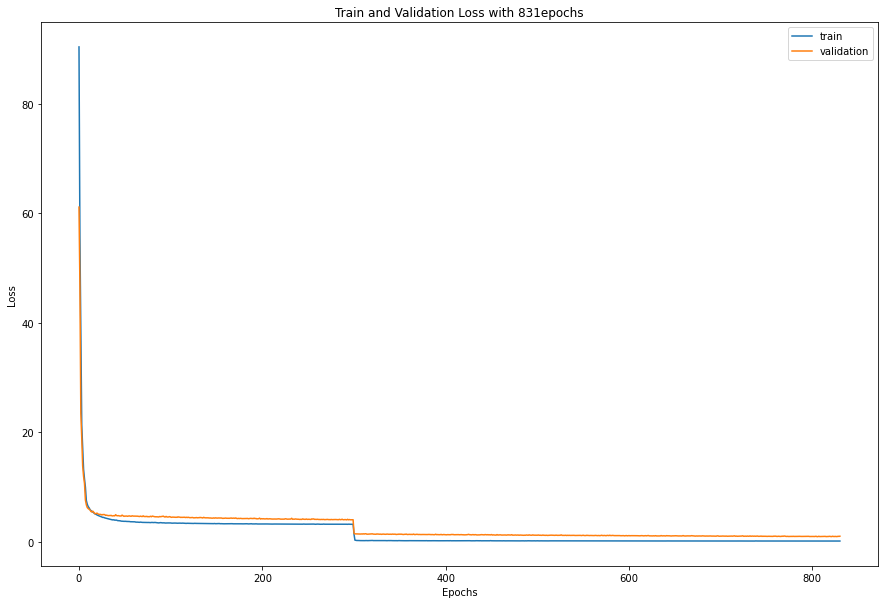

In [26]:
patience=25
# plotting training and validation history
plt.figure(figsize=(15,10))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [27]:
predict1=np.zeros((82)) #82
predict1=predictions[-3]
    
predict2=np.zeros((82))
predict2=predictions[-2]
    
predict3=np.zeros((82))
predict3=predictions[-1]

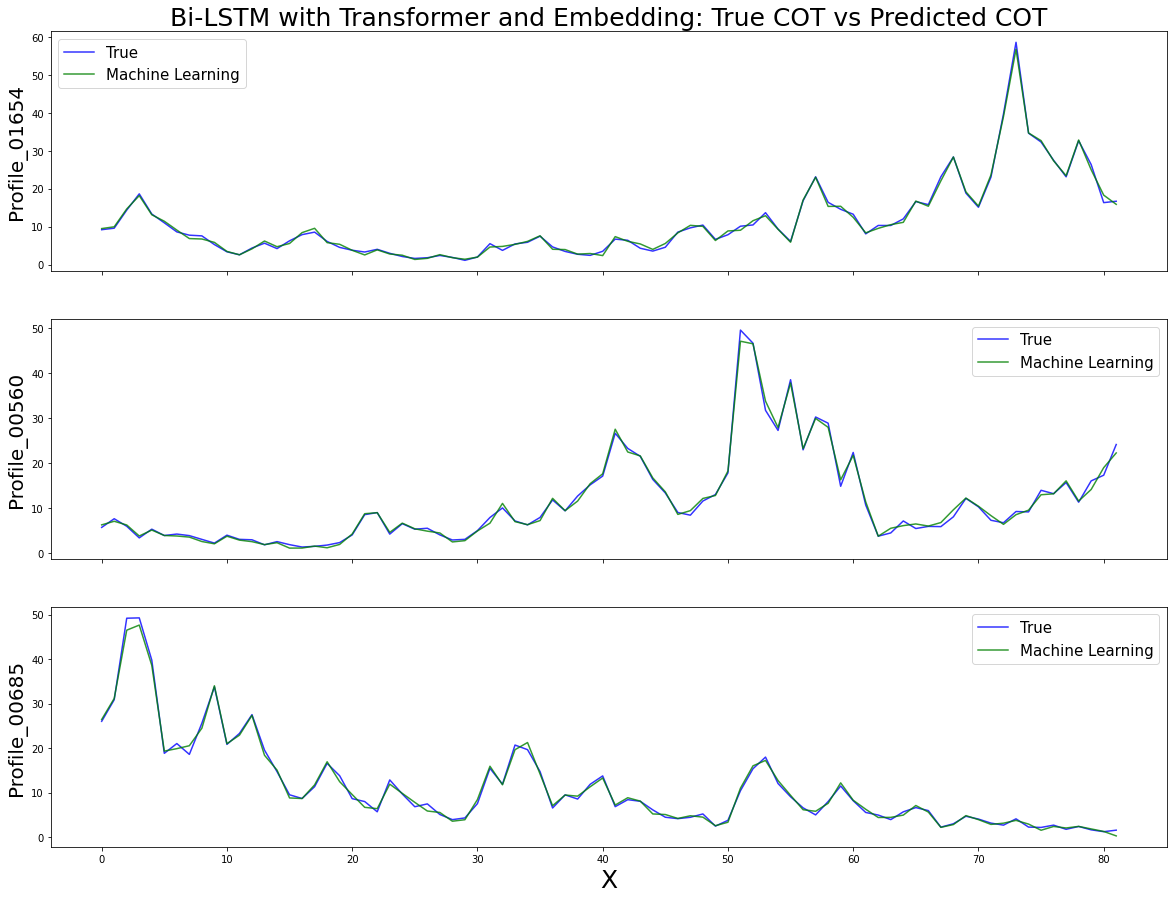

In [72]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/predict_Bi-LSTM with transformer embedding"+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM with Transformer and Embedding: True COT vs Predicted COT",fontsize=25)
ax.plot(range(82),c[num-3],alpha=0.8,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.8,color="green") 
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.8,color="blue")
ax.plot(range(82),predict2,alpha=0.8,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_00560",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1],alpha=0.8,color="blue")
ax.plot(range(82),predict3,alpha=0.8,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_00685",fontsize=20)  
ax.set_xlabel('X',fontsize=25)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

In [30]:
c.shape

(2000, 82)

In [32]:
num

2000

In [38]:
cot=np.load('monte_carlo_cot.npy')


In [39]:
for i in range(2000):
    if np.array_equal(c[num-1],cot[i]):
        print(i+1)


685


In [59]:
for i in range(2000):
    if np.array_equal(c[num-2],cot[i]):
        print(i+1)

560


In [60]:
for i in range(2000):
    if np.array_equal(c[num-3],cot[i]):
        print(i+1)

1654


In [46]:
c[num-1]

array([26.02168511, 30.8691409 , 49.19559409, 49.27134464, 39.78503805,
       18.82954932, 21.02808581, 18.59109019, 25.604808  , 33.77063738,
       20.83855849, 23.30020894, 27.51875026, 19.55374308, 14.70965305,
        9.50896693,  8.67738263, 11.33319606, 16.56696631, 13.79369581,
        8.644931  ,  7.99096835,  5.68966357, 12.85294214,  9.6904286 ,
        6.82404758,  7.46588333,  5.08154638,  3.9264859 ,  4.30768329,
        7.53108258, 15.45422042, 11.88875473, 20.68848566, 19.65331808,
       14.72227666,  6.54093552,  9.49288714,  8.55521055, 11.86677936,
       13.75321138,  6.84271818,  8.41293243,  8.05102553,  6.11911092,
        4.46676535,  4.14606506,  4.4522269 ,  5.20601755,  2.4708528 ,
        3.77133796, 10.43003427, 15.36832365, 17.98168245, 12.0394931 ,
        9.06712968,  6.57842707,  4.9897247 ,  7.9997627 , 11.48747821,
        8.17692705,  5.53927807,  4.95379669,  3.92983819,  5.67845066,
        6.63508541,  5.96034917,  2.23681098,  2.99781625,  4.68

In [61]:
fname1= "D:\\code\\Fiona\\climate project\\Monte_carlo_real/profile_00685.hdf5"
hf = h5py.File(fname1, 'r')
sza=hf['SZA'][:]
print('SZA',sza)

vza=hf['VZA'][:]
print('VZA',vza)

SZA [46.48061134]
VZA [ 51.44980615 -51.44980615]


In [63]:
fname1= "D:\\code\\Fiona\\climate project\\Monte_carlo_real/profile_01654.hdf5"
hf = h5py.File(fname1, 'r')
sza=hf['SZA'][:]
print('SZA',sza)

vza=hf['VZA'][:]
print('VZA',vza)

SZA [44.78948825]
VZA [ 39.8343166 -39.8343166]


In [4]:
fname1= "D:\\code\\Fiona\\climate project\\Monte_carlo_real/profile_00560.hdf5"
hf = h5py.File(fname1, 'r')
sza=hf['SZA'][:]
print('SZA',sza)

vza=hf['VZA'][:]
print('VZA',vza)

SZA [68.27821533]
VZA [ 65.34206243 -65.34206243]


In [58]:
np.mean(np.array(cott)[50:100])

30.869140899020866

# Plotting across predicted 82 COT values¶

In [29]:
std=[]
mean=[]

for k in range(82):#82
    tmp=[]
    for j in range(400): #test set
        tmp.append(np.abs(predictions[j][k]-test_label[j][k])) #absolute difference 
    std.append(np.std(tmp))
    mean.append(np.mean(tmp)) #### replace with RMSE 
    

std=np.array(std) #sd of the absolute difference of the 800 profiles at each cot values. 
mean=np.array(mean) #mean absolute difference between the predicted value and the orginal values of 800 profiles at each cot value
std1 = np.std(mean) #standard deviation of the mean absolute difference across the 82 cot values 

# plot std, std1
# histogram of mean and histogram of std


In [64]:
mean

array([1.0713908 , 1.10738603, 0.83744641, 0.76391557, 0.66249362,
       0.68581399, 0.69161965, 0.74400743, 0.69152275, 0.73591934,
       0.72852752, 0.62522212, 0.57508762, 0.55540797, 0.68791071,
       0.70671023, 0.73194413, 0.6472055 , 0.60544804, 0.69177902,
       0.72167078, 0.75698844, 0.65234101, 0.63097325, 0.68083864,
       0.67402728, 0.59677227, 0.57631114, 0.63058379, 0.67200653,
       0.66749403, 0.7666778 , 0.69549362, 0.61942253, 0.59071688,
       0.59320919, 0.64631184, 0.64629411, 0.7704347 , 0.73955221,
       0.69337509, 0.72852284, 0.73913206, 0.63738005, 0.61500199,
       0.61757739, 0.65370131, 0.66208895, 0.69438204, 0.65719273,
       0.61959611, 0.66004266, 0.65817416, 0.63255436, 0.66556245,
       0.71038343, 0.6992612 , 0.67587368, 0.63784188, 0.70430413,
       0.61764718, 0.77501505, 0.67751768, 0.66098033, 0.67612273,
       0.54838976, 0.62397841, 0.58025655, 0.57361877, 0.62216604,
       0.59188195, 0.63022989, 0.66501629, 0.65543214, 0.68250

In [65]:
predictions.shape

(400, 82)

In [66]:
hist_m, bins_m = np.histogram(mean)
hist_s, bins_s = np.histogram(std)

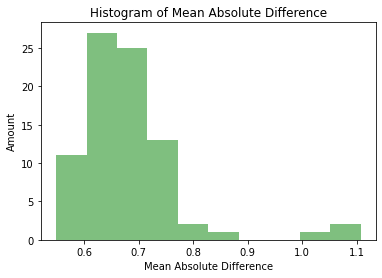

In [67]:
n, bins, patches = plt.hist(mean,bins=10,color='green',alpha=0.5)

plt.xlabel('Mean Absolute Difference')
plt.ylabel('Amount')

plt.title('Histogram of Mean Absolute Difference')

plt.show()

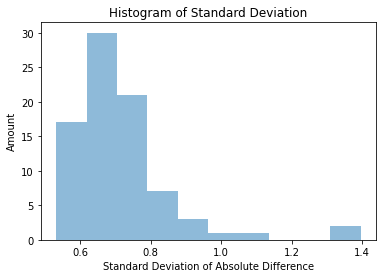

In [68]:
n, bins, patches = plt.hist(std,bins=10,histtype='bar',alpha=0.5)

plt.xlabel('Standard Deviation of Absolute Difference')
plt.ylabel('Amount')

plt.title('Histogram of Standard Deviation')

plt.show()

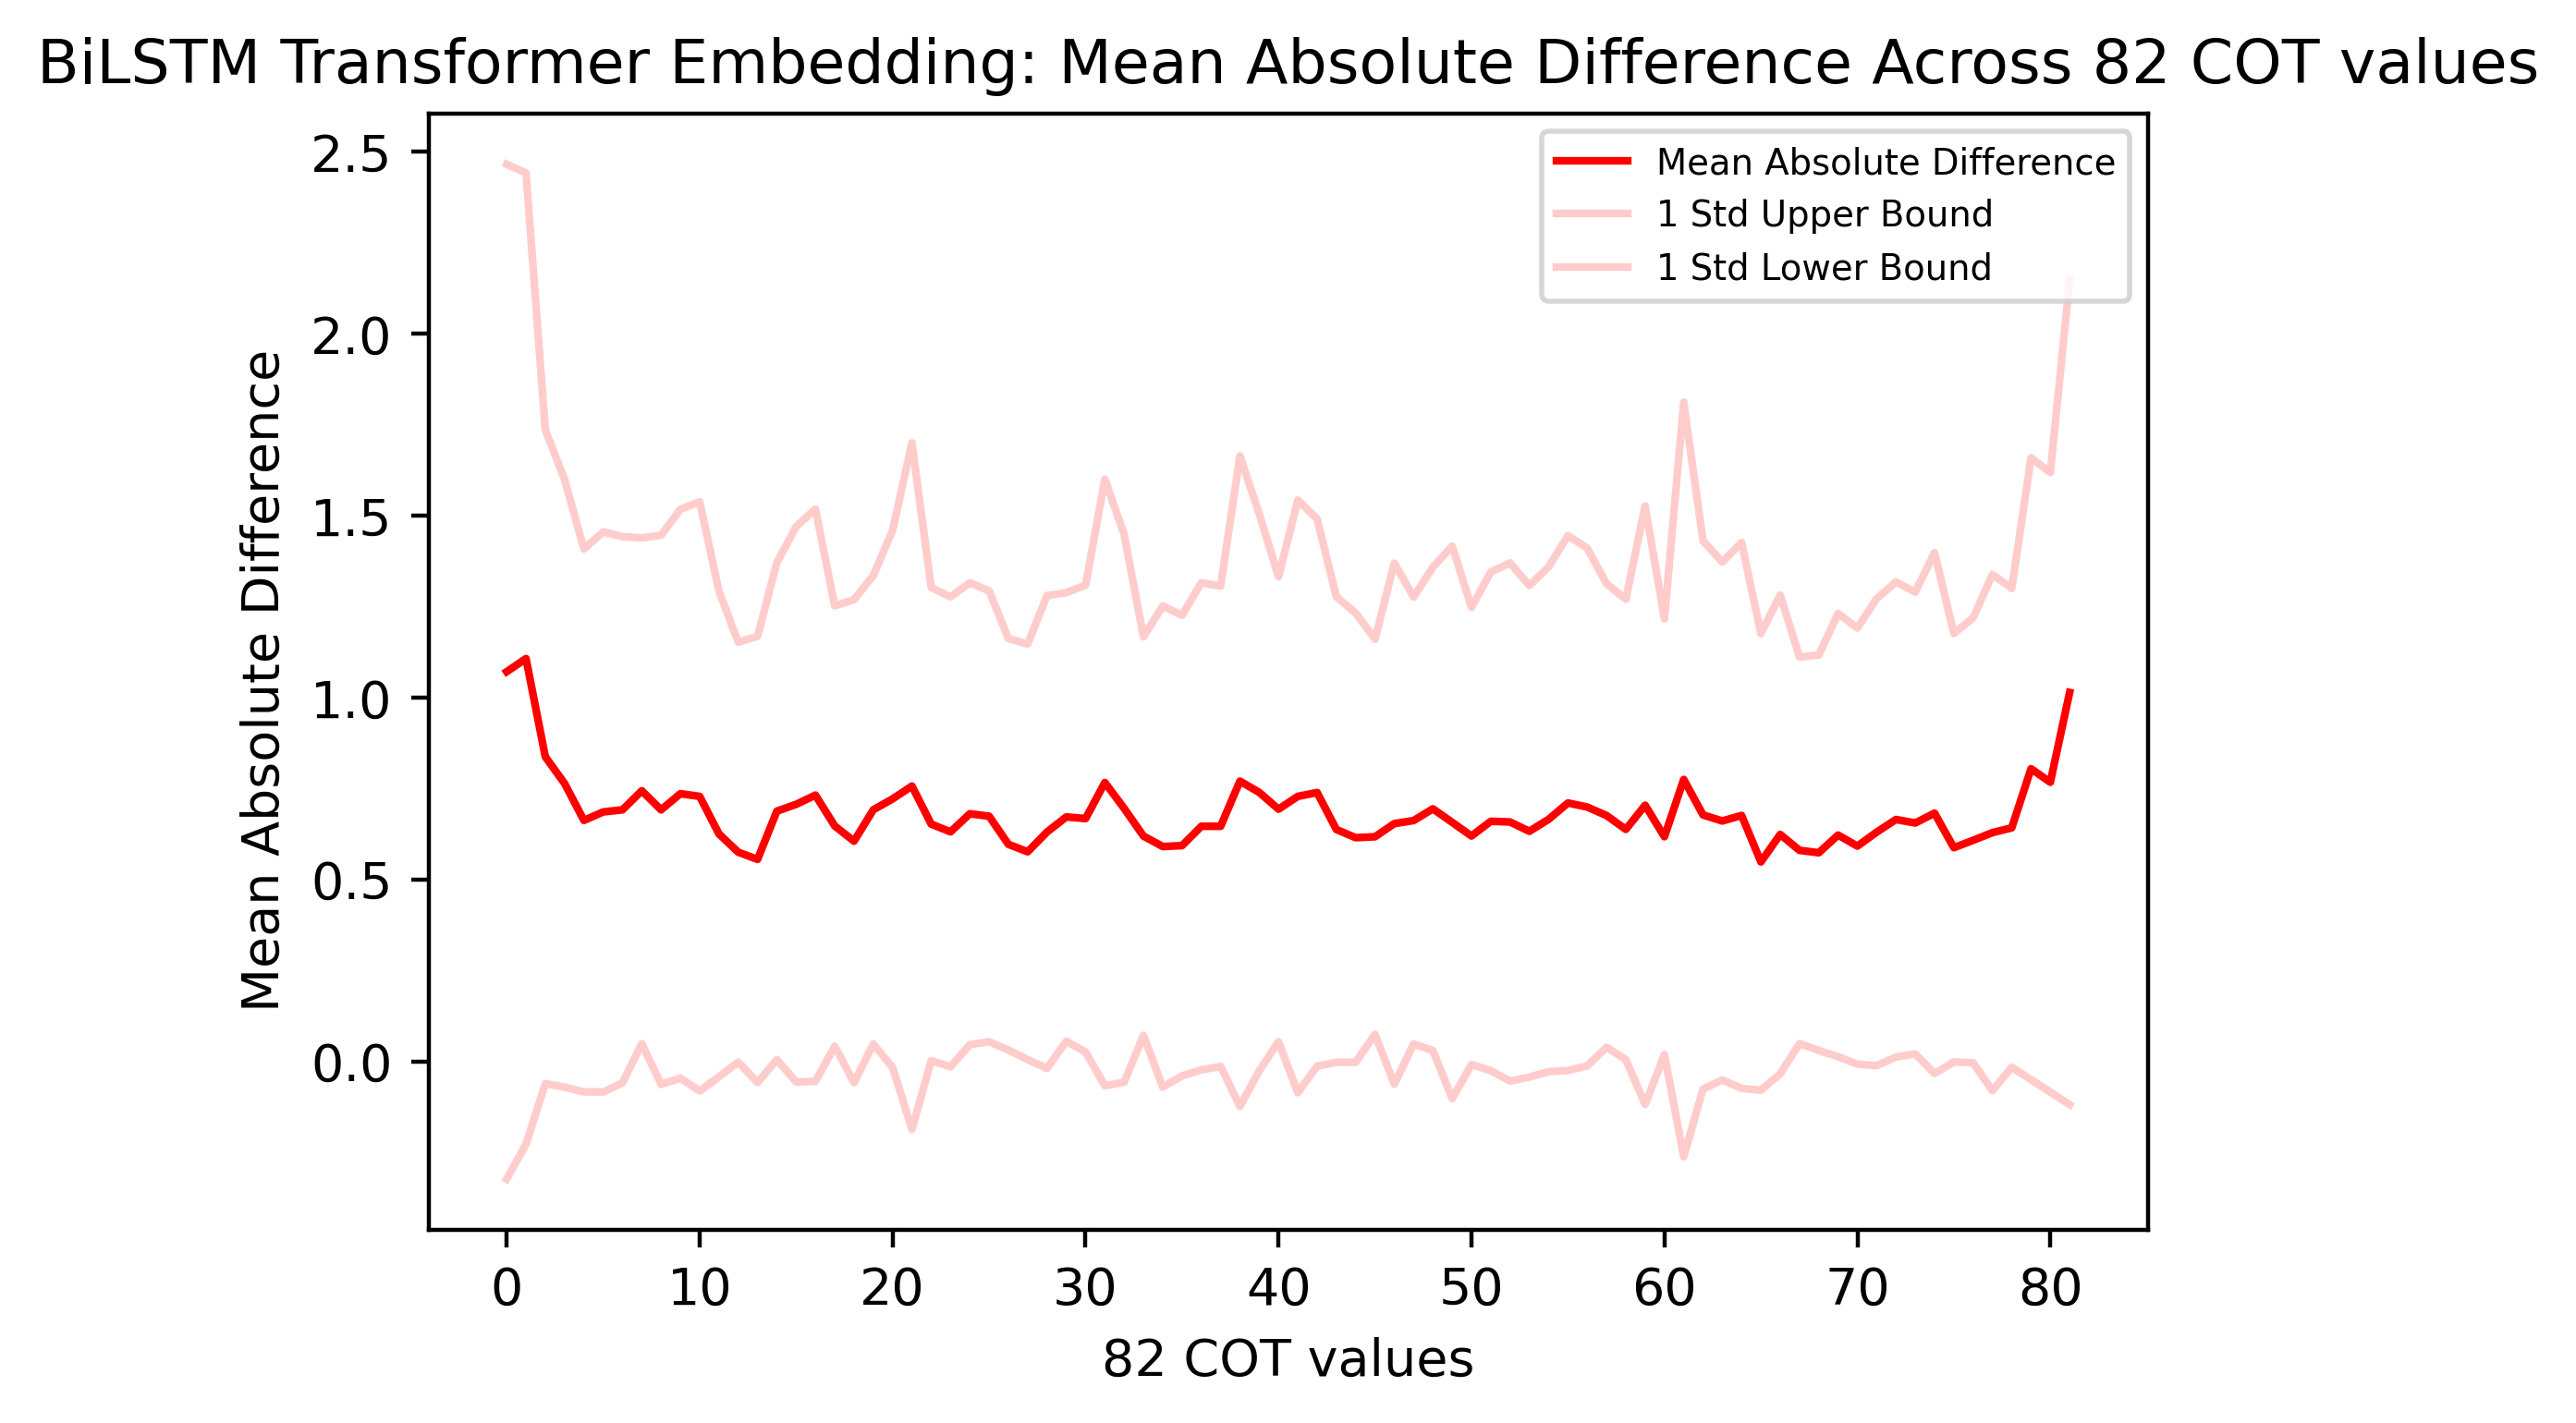

In [69]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
#ax.set_ylim((-0.5,1))
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM_with_ Transformer_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

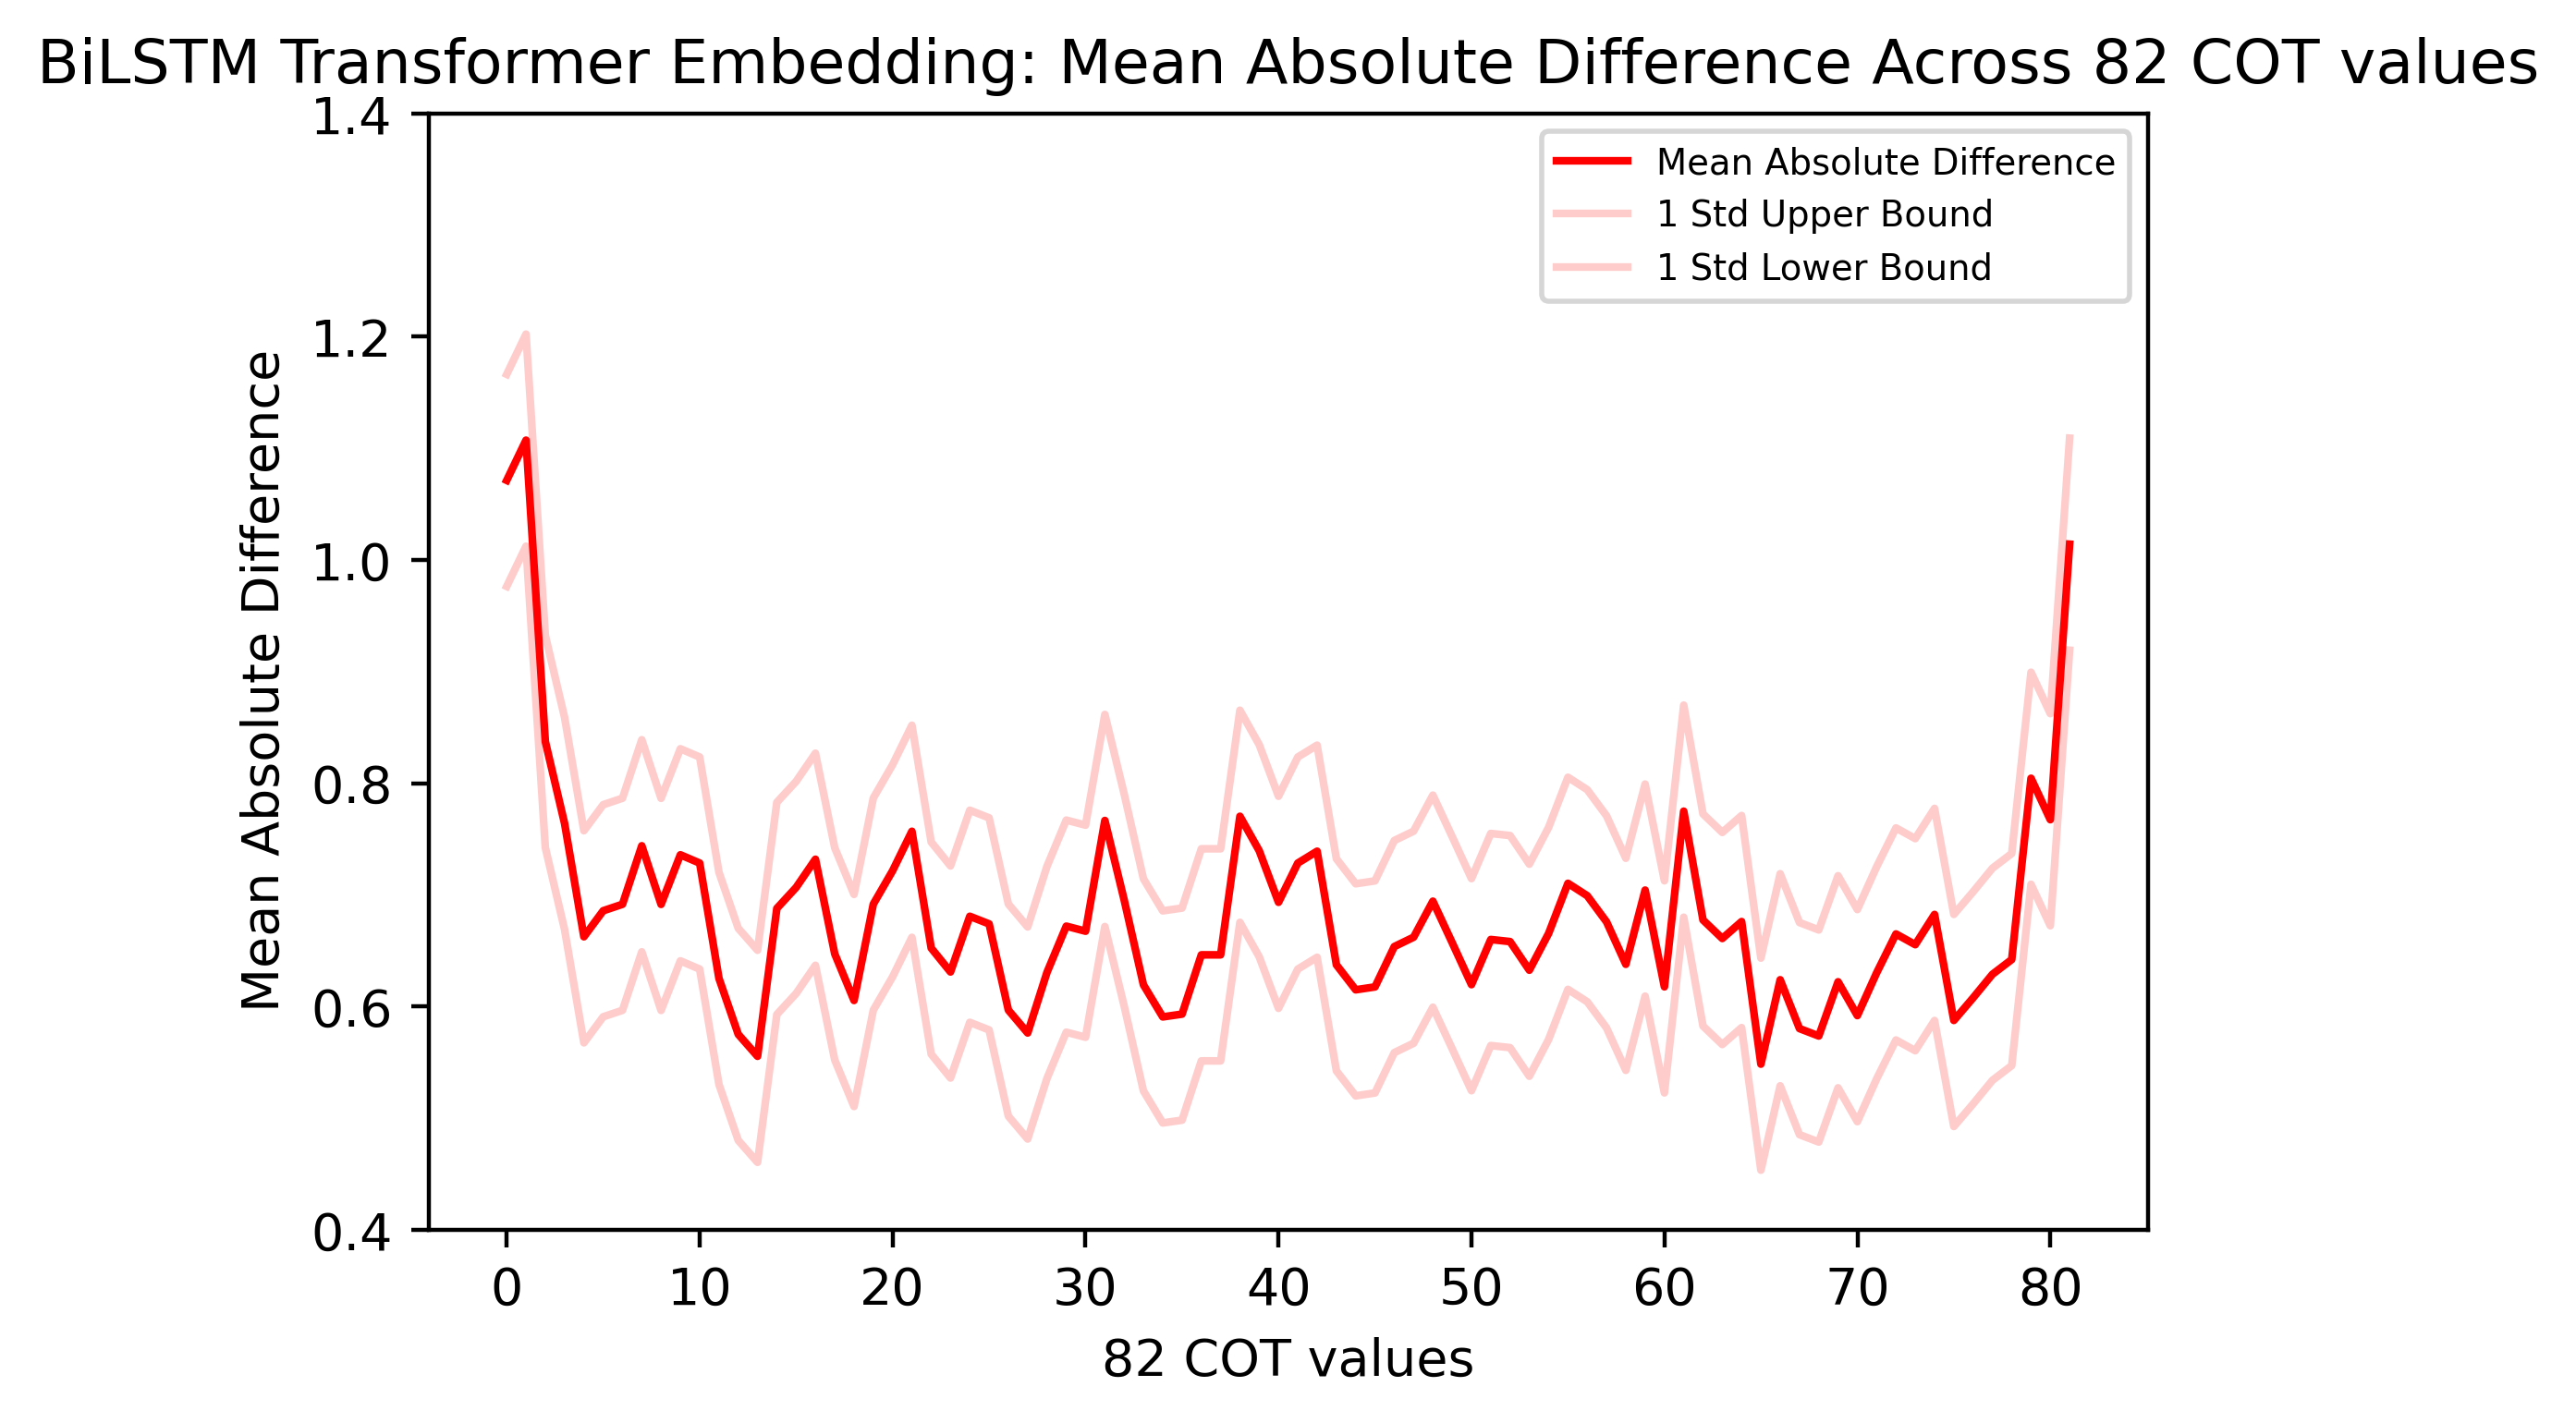

In [71]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std1, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std1, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylim((0.4,1.4))
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM_with_ Transformer_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)
